## Pipeline (subject to change)

## INPUTS and OUTPUTS (SET BY USER)

In [232]:
# INPUTS
input_file = 'ENIGMA_BigStudy_LIPIDS_POS_RAW_20230327_AgeGroups_20231110.csv' #'Coffee_Beans_HILIC_POS_RAW_20240105.csv'
input_batch_info_file = 'ENIGMA_BigStudy_LIPIDS_POS_RAW_20230327_AgeGroups_20231110_InputFiles.csv'#'Coffee_Beans_HILIC_POS_RAW_20240105_InputFiles.csv'

# OUTPUTS
output_file_prefix = 'ENIGMA_BigStudy_LIPIDS' #'Coffee_Beans_HILIC_POS'
report_file_name = 'ENIGMA_BigStudy_LIPIDS-report.pdf' #'Coffee_Beans_HILIC_POS-report'

# OUTPUT FOLDER
main_folder = 'ENIGMA_analysis' #'Coffee_analysis-POS'

## Creating folders

In [233]:
import os

# Create the directory if it doesn't exist
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

# Create the directory if it doesn't exist
if not os.path.exists(main_folder + '/figures'):
    os.makedirs(main_folder + '/figures')

### Loading models

In [234]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import time
import math
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import LeaveOneOut
from scipy.stats import zscore
from itertools import cycle

## Image formats to save

In [235]:
# To work properly always save atleast png version of the figures
sufixes = ['.png', '.pdf'] # sufices for the image files to be saved in

### Setting up the report file

In [236]:
import pdf_reporter as pdf_rptr

# Reload the module to get the latest changes
# This will be deleted later, just for testing purposes
import importlib
importlib.reload(pdf_rptr)



#---------------------------------------------
# REPORTING
report_path = main_folder + '/' + report_file_name + '.pdf'
title_text = main_folder

report = pdf_rptr.Report(name = report_path, title = title_text)
report.initialize_report('processing')

### Loading data

In [237]:
def load_data(data_input_file_name, separator = ';', encoding = 'ISO-8859-1'):
    # Step 1: Read the data_df from Compound Discoverer file
    data_file = input_file  # Update with your file path
    data_df = pd.read_csv(data_input_file_name, sep = separator,  encoding=encoding )
    #---------------------------------------------
    # REPORTING
    text = 'Data were loaded from: ' + data_file + ' (data from Compound Discoverer).'
    report.add_together([('text', text), 
                        ('table', data_df),
                        'line'])
    return data_df

data_df = load_data(input_file, separator = ',', encoding = 'UTF-8')

### cpdID

In [238]:
def add_cpdID(df, mz_col, rt_col):
    #add cpdID column to the data_df calculated from mz and RT
    df['cpdID'] = 'M' + df[mz_col].round(0).astype(int).astype(str) + 'T' + (df[rt_col]*60).round(0).astype(int).astype(str)
    # Create a new column 'Duplicate_Count' to keep track of the duplicates
    df['Duplicate_Count'] = df.groupby('cpdID').cumcount()
    # Create a mask to identify duplicated compounds
    is_duplicate = df['Duplicate_Count'] > 0
    # Update the 'Compound_ID' column for duplicated compounds
    df.loc[is_duplicate, 'cpdID'] = df['cpdID'] + '_' + (df['Duplicate_Count']).astype(str)
    # Drop the 'Duplicate_Count' 
    df.drop('Duplicate_Count', axis=1, inplace=True)
    #check if there are rly no duplicates left
    remaining_duplicates = df[df['cpdID'].duplicated(keep=False)]
    print(remaining_duplicates.empty)

    #---------------------------------------------
    # REPORTING
    text = 'cpdID column was added to the data_df calculated from mz and RT. Matching ID - distinguished by adding "_1", "_2", etc.'
    report.add_together([('text', text),
                            'line'])
add_cpdID(data_df, 'm/z', 'RT [min]')


data_df

True


,Tags,Checked,Name,Formula,Annot. Source: Predicted Compositions,Annot. Source: mzCloud Search,Annot. Source: mzVault Search,Annot. Source: Metabolika Search,Annot. Source: ChemSpider Search,Annot. Source: MassList Search,...,Area: SRM_POS_B07_C30_02.raw (F1995),Area: SRM_POS_B08_C30_01.raw (F2247),Area: SRM_POS_B08_C30_02.raw (F2248),Area: SRM_POS_B09_C30_01.raw (F2500),Area: SRM_POS_B09_C30_02.raw (F2501),Area: SRM_POS_B10_C30_01.raw (F2754),Area: SRM_POS_B10_C30_02.raw (F2755),Area: SRM_POS_B11_C30_01.raw (F3015),Area: SRM_POS_B11_C30_02.raw (F3016),cpdID
0,NaN,False,NaN,C25 H49 N O,Full match,No results,No results,No results,No results,No results,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M380T310
1,NaN,False,DGGA 16:0_16:2,C41 H72 O11,No results,No results,Invalid mass,No results,No results,No match,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M759T689
2,NaN,False,NaN,NaN,No results,No results,No results,No results,No results,No results,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M954T944
3,NaN,False,NaN,NaN,No results,No results,No results,No results,No results,No results,...,NaN,NaN,1.771760e+06,NaN,NaN,NaN,NaN,NaN,NaN,M969T960
4,NaN,False,PC 18:2_34:3,C60 H110 N O8 P,No results,No results,Full match,No results,No results,No results,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M1005T808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27609,NaN,False,PC 18:0_20:4,C46 H84 N O8 P,No match,No results,Full match,No results,No results,Partial match,...,1.259991e+09,1.500453e+09,1.540911e+09,1.603114e+09,1.352724e+09,8.320805e+08,8.179350e+08,6.278676e+08,9.304066e+08,M811T683
27610,NaN,False,PC 18:2_18:2,C44 H80 N O8 P,Not the top hit,No results,Full match,No results,No results,Partial match,...,2.897243e+09,NaN,2.918625e+09,3.051388e+09,2.990131e+09,1.804052e+09,1.548575e+09,6.862707e+07,NaN,M783T536_1
27611,NaN,False,PC 16:0_18:1,C42 H82 N O8 P,No match,No results,Full match,No results,No results,Partial match,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M761T656_1
27612,NaN,False,PC 18:0_18:2,C44 H84 N O8 P,No match,No results,Full match,No results,No results,Partial match,...,2.821660e+09,3.159117e+09,3.101453e+09,3.608852e+09,2.956605e+09,1.626225e+09,1.574694e+09,1.287888e+09,2.655333e+09,M787T704


## Creating different matrices

### variable_metadata

In [239]:
def extract_variable_data(data_df):
    variable_metadata = data_df[['cpdID', 'Name', 'Formula']]
    variable_metadata = variable_metadata.join(data_df.iloc[:, 10:15])
    variable_metadata = variable_metadata.join(data_df.iloc[:, 18:23])
    variable_metadata = variable_metadata.join(data_df.iloc[:, 32:34])

    #---------------------------------------------
    # REPORTING
    text = 'variable-metadata matrix was created.'
    report.add_together([('text', text),
                            'line'])
    return variable_metadata

variable_metadata = extract_variable_data(data_df)
variable_metadata


,cpdID,Name,Formula,Annot. DeltaMass [ppm],Calc. MW,m/z,RT [min],Area (Max.),mzCloud Best Match,mzCloud Best Match Confidence,mzCloud Best Sim. Match,mzCloud Best Tree Match,mzVault Best Match,Area: L2560_F_Group02_F_Group02_POS_B01_C30.raw (F385),Area: L2676_F_Group11_POS_B01_C30.raw (F404)
0,M380T310,NaN,C25 H49 N O,-1.46,379.38086,380.38814,5.166,1.675050e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M759T689,DGGA 16:0_16:2,C41 H72 O11,22998.17,757.53778,758.54506,11.489,3.204193e+06,NaN,NaN,NaN,NaN,0.1,NaN,NaN
2,M954T944,NaN,NaN,NaN,952.78273,953.79001,15.726,4.110797e+06,NaN,NaN,NaN,NaN,NaN,NaN,9.059247e+05
3,M969T960,NaN,NaN,NaN,967.82427,968.83155,16.004,5.375985e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M1005T808,PC 18:2_34:3,C60 H110 N O8 P,0.10,1003.79700,1004.80428,13.462,2.768978e+06,NaN,NaN,NaN,NaN,0.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27609,M811T683,PC 18:0_20:4,C46 H84 N O8 P,2.27,809.59529,810.60279,11.381,4.484154e+09,NaN,NaN,NaN,NaN,57.9,NaN,5.137686e+07
27610,M783T536_1,PC 18:2_18:2,C44 H80 N O8 P,1.42,781.56326,782.57061,8.932,7.455106e+09,NaN,NaN,NaN,NaN,56.9,2.454394e+09,2.364255e+09
27611,M761T656_1,PC 16:0_18:1,C42 H82 N O8 P,-2.13,759.57619,760.58349,10.930,1.057624e+10,NaN,NaN,NaN,NaN,56.1,2.945470e+09,3.969924e+09
27612,M787T704,PC 18:0_18:2,C44 H84 N O8 P,2.06,785.59507,786.60239,11.740,9.705746e+09,NaN,NaN,NaN,NaN,58.6,NaN,NaN


### data

In [240]:
def extract_data(data_df, prefix = 'Area:'):
    data = data_df[['cpdID']]
    # Select columns with names starting with "Area:"
    area_columns = data_df.filter(regex=r'^' + prefix, axis=1) #for those starting with Area:, for those including Area anywhere, you can use like='Area:'
    data = data.join(data_df[area_columns.columns])

    # Fill NaN values with zero (NaN values are problem when plotted, and we will treat 0s as missing values later)
    data.fillna(0, inplace=True)  # Replace NaN with 0

    #---------------------------------------------
    # REPORTING
    text = 'data matrix was created.'
    report.add_together([('text', text),
                            'line'])
    return data

data = extract_data(data_df)
data

,cpdID,Area: L2552_F_Group09_POS_B01_C30.raw (F377),Area: L2560_F_Group02_F_Group02_POS_B01_C30.raw (F385),Area: L2676_F_Group11_POS_B01_C30.raw (F404),Area: L2727_F_Group04_POS_B01_C30.raw (F432),Area: L2759_F_Group01_POS_B01_C30.raw (F454),Area: L2775_F_Group05_POS_B02_C30.raw (F619),Area: L2782_F_Group18_POS_B02_C30.raw (F626),Area: L2786_F_Group09_POS_B02_C30.raw (F630),Area: L2804_F_Group18_POS_B02_C30.raw (F632),...,Area: SRM_POS_B07_C30_01.raw (F1994),Area: SRM_POS_B07_C30_02.raw (F1995),Area: SRM_POS_B08_C30_01.raw (F2247),Area: SRM_POS_B08_C30_02.raw (F2248),Area: SRM_POS_B09_C30_01.raw (F2500),Area: SRM_POS_B09_C30_02.raw (F2501),Area: SRM_POS_B10_C30_01.raw (F2754),Area: SRM_POS_B10_C30_02.raw (F2755),Area: SRM_POS_B11_C30_01.raw (F3015),Area: SRM_POS_B11_C30_02.raw (F3016)
0,M380T310,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,M759T689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,M954T944,0.000000e+00,0.000000e+00,9.059247e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,M969T960,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.771760e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,M1005T808,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27609,M811T683,1.014720e+09,0.000000e+00,5.137686e+07,8.059443e+08,0.000000e+00,9.751099e+08,7.558440e+07,1.769308e+09,4.772079e+08,...,8.832616e+08,1.259991e+09,1.500453e+09,1.540911e+09,1.603114e+09,1.352724e+09,8.320805e+08,8.179350e+08,6.278676e+08,9.304066e+08
27610,M783T536_1,2.274783e+09,2.454394e+09,2.364255e+09,2.196598e+09,1.725828e+09,2.985997e+09,2.575338e+09,5.263510e+09,1.371267e+09,...,2.775353e+09,2.897243e+09,0.000000e+00,2.918625e+09,3.051388e+09,2.990131e+09,1.804052e+09,1.548575e+09,6.862707e+07,0.000000e+00
27611,M761T656_1,2.457231e+09,2.945470e+09,3.969924e+09,3.542647e+09,3.401575e+09,0.000000e+00,3.119104e+09,0.000000e+00,3.305131e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
27612,M787T704,3.074982e+09,0.000000e+00,0.000000e+00,3.283268e+09,3.035394e+09,4.698966e+09,0.000000e+00,4.425502e+09,4.331460e+09,...,3.201904e+09,2.821660e+09,3.159117e+09,3.101453e+09,3.608852e+09,2.956605e+09,1.626225e+09,1.574694e+09,1.287888e+09,2.655333e+09


In [241]:
def load_batch_info(input_batch_info_file):
    #but better will be get it straight from the xml file (will do later)
    batch_info = pd.read_csv(input_batch_info_file, sep = ';')
    batch_info

    #---------------------------------------------
    # REPORTING
    text = 'batch_info matrix was loaded from: ' + input_batch_info_file
    report.add_together([('text', text),
                            'line'])
    return batch_info

batch_info = load_batch_info(input_batch_info_file)
batch_info

,Study File ID,File Name,Creation Date,RT Range [min],Instrument Name,Software Revision,Ref. File ID,Alignment Score,Sample Type,Polarity,Sex,AgeGroup,Max. Mass [Da]
0,F468,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,30.08.2022 19:56,0.00 - 29.99,Orbitrap Elite,2.7.0 SP2,F1479,0.367,Identification Only,POS,QC,QC,2000
1,F469,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,30.08.2022 20:27,0.00 - 29.99,Orbitrap Elite,2.7.0 SP2,F1479,0.377,Identification Only,POS,QC,QC,2000
2,F470,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,30.08.2022 20:59,0.00 - 30.01,Orbitrap Elite,2.7.0 SP2,F1479,0.302,Identification Only,POS,QC,QC,2000
3,F491,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,30.08.2022 21:30,0.00 - 29.99,Orbitrap Elite,2.7.0 SP2,F1479,0.874,Sample,POS,SRM,SRM,2000
4,F471,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,30.08.2022 22:01,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.961,Quality Control,POS,QC,QC,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,F2937,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,14.01.2023 7:36,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.868,Sample,POS,M,Group12,2000
1380,F3013,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,14.01.2023 8:07,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.887,Quality Control,POS,QC,QC,2000
1381,F3014,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,14.01.2023 8:38,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.888,Quality Control,POS,QC,QC,2000
1382,F3016,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,14.01.2023 9:10,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.812,Sample,POS,SRM,SRM,2000


In [242]:
# def batch_by_date(data, batch_info, format='%d.%m.%Y %H:%M'):
#     # # Based on the order of the samples from batch_info, we can sort the data
#     # ##----------
#     # ## IN THIS CASE WE HAVE DATA ORDERED ALREADY SORTED BY THE CREATION DATE
#     # ##----------

#     # Convert the 'Creation Date' column to datetime format
#     batch_info['Creation Date'] = pd.to_datetime(batch_info['Creation Date'], format = format) #, dayfirst=True

#     # Sort the DataFrame based on the 'Creation Date' column
#     batch_info = batch_info.sort_values('Creation Date')

#     #Sort data based on the order of the samples from batch_info
#     not_found = []
#     not_found_indexes = []
#     new_data_order = []
#     names = data.columns[1:].to_list().copy()
#     for i, id in enumerate(batch_info['Study File ID'].tolist()):
#         found = False
#         for name in names:
#             # Check if the name contains the ID within brackets
#             if re.search(f'\({id}\)', name):
#                 new_data_order.append(name)
#                 found = True
#                 names.pop(names.index(name))
#                 break
#         if not found:
#             not_found_indexes.append(i)
#             not_found.append([id, batch_info['Sample Type'].tolist()[i]])

#     print("Not found: " + str(len(not_found)) + " ;being: " + str(not_found))
#     print("Names not identified: " + str(len(names)) + " ;being: " + str(names))

#     #omit not found samples from batch_info
#     batch_info = batch_info.drop(not_found_indexes)
#     batch_info = batch_info.reset_index(drop=True)

#     #reorder data
#     data = data[['cpdID']+new_data_order]
#     #---------------------------------------------
#     #REPORTING
#     text0 = 'Batch information from file:'+ input_batch_info_file +' was used to (re)order samples.'
#     text1 = 'Not found: ' + str(len(not_found)) + ' ;being: ' + str(not_found)
#     text2 = 'Names not identified: ' + str(len(names)) + ' ;being: ' + str(names)
#     report.add_together([('text', text0),
#                         ('text', text1, 'italic'),
#                         ('text', text2, 'italic'),
#                         ('table', batch_info),
#                         'line'])
#     return data, batch_info




#---------------------------------------------
# REORDER DATA BASED ON THE CREATION DATE, ADD A COLUMN 'Batch' TO THE BATCH_INFO BASED ON DISTINGUISHER
#---------------------------------------------
def batch_by_name(data, batch_info, distinguisher = 'BigBatch', format='%d.%m.%Y %H:%M'):
    #Batches are distinguished in the File Name *_distinguisher_XXX
    batches_column = []

    names = data.columns[1:].to_list()
    batch_names = batch_info['File Name'].tolist()

    # Convert the 'Creation Date' column to datetime format
    batch_info['Creation Date'] = pd.to_datetime(batch_info['Creation Date'], format = format) #, dayfirst=True

    # Sort the DataFrame based on the 'Creation Date' column
    batch_info = batch_info.sort_values('Creation Date')

    for name in batch_names:
        split_name = re.split(r'[_|\\]', name) #split by _ or \
        for i, part in enumerate(split_name):
            if part == distinguisher:
                batches_column.append(split_name[i+1])
                break

    if len(batches_column) == 0:
        raise ValueError("No matches found in 'names' for the distinguisher: " + distinguisher + " in the file names.")
    else:
        batch_info['Batch'] = batches_column

    # Omit not found samples from batch_info
    not_found = []
    not_found_indexes = []
    new_data_order = []
    for i, id in enumerate(batch_info['Study File ID'].tolist()):
        found = False
        for name in names:
            # Check if the name contains the ID within brackets
            if re.search(f'\({id}\)', name):
                found = True
                new_data_order.append(name)
                names.pop(names.index(name))
                break
        if not found:
            not_found_indexes.append(i)
            not_found.append([id, batch_info['Sample Type'].tolist()[i]])

    print("Not found: " + str(len(not_found)) + " ;being: " + str(not_found))
    print("Names not identified: " + str(len(names)) + " ;being: " + str(names))

    # Reorder data
    data = data[['cpdID']+new_data_order]


    batch_info = batch_info.drop(not_found_indexes)
    batch_info = batch_info.reset_index(drop=True)

    #---------------------------------------------
    #REPORTING
    text0 = 'Batch information from file:'+ input_batch_info_file +' was used to (re)order samples.'
    text1 = 'Not found: ' + str(len(not_found)) + ' ;being: ' + str(not_found)
    text2 = 'Names not identified: ' + str(len(names)) + ' ;being: ' + str(names)
    report.add_together([('text', text0),
                        ('text', text1, 'italic'),
                        ('text', text2, 'italic'),
                        ('table', batch_info),
                        'line'])

    return data, batch_info


#data, batch_info = batch_by_date(data, batch_info, format = '%d.%m.%Y %H:%M')
data, batch_info = batch_by_name(data, batch_info, distinguisher = 'BigBatch', format = '%d.%m.%Y %H:%M')

Not found: 33 ;being: [['F468', 'Identification Only'], ['F469', 'Identification Only'], ['F470', 'Identification Only'], ['F715', 'Identification Only'], ['F716', 'Identification Only'], ['F717', 'Identification Only'], ['F963', 'Identification Only'], ['F964', 'Identification Only'], ['F965', 'Identification Only'], ['F1212', 'Identification Only'], ['F1213', 'Identification Only'], ['F1214', 'Identification Only'], ['F1468', 'Identification Only'], ['F1469', 'Identification Only'], ['F1470', 'Identification Only'], ['F1718', 'Identification Only'], ['F1719', 'Identification Only'], ['F1720', 'Identification Only'], ['F1971', 'Identification Only'], ['F1972', 'Identification Only'], ['F1973', 'Identification Only'], ['F2224', 'Identification Only'], ['F2225', 'Identification Only'], ['F2226', 'Identification Only'], ['F2477', 'Identification Only'], ['F2478', 'Identification Only'], ['F2479', 'Identification Only'], ['F2731', 'Identification Only'], ['F2732', 'Identification Only'], 

In [243]:
batch_info

,Study File ID,File Name,Creation Date,RT Range [min],Instrument Name,Software Revision,Ref. File ID,Alignment Score,Sample Type,Polarity,Sex,AgeGroup,Max. Mass [Da],Batch
0,F491,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 21:30:00,0.00 - 29.99,Orbitrap Elite,2.7.0 SP2,F1479,0.874,Sample,POS,SRM,SRM,2000,001
1,F471,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 22:01:00,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.961,Quality Control,POS,QC,QC,2000,001
2,F472,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 22:32:00,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.959,Quality Control,POS,QC,QC,2000,001
3,F433,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 23:04:00,0.00 - 29.99,Orbitrap Elite,2.7.0 SP2,F1479,0.941,Sample,POS,M,Group09,2000,001
4,F463,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 23:35:00,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.934,Sample,POS,M,Group04,2000,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,F2937,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 07:36:00,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.868,Sample,POS,M,Group12,2000,011
1347,F3013,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 08:07:00,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.887,Quality Control,POS,QC,QC,2000,011
1348,F3014,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 08:38:00,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.888,Quality Control,POS,QC,QC,2000,011
1349,F3016,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 09:10:00,0.00 - 30.00,Orbitrap Elite,2.7.0 SP2,F1479,0.812,Sample,POS,SRM,SRM,2000,011


In [244]:
data

,cpdID,Area: SRM_POS_B01_C30_01.raw (F491),Area: QC_POS_B01_C30_09.raw (F471),Area: QC_POS_B01_C30_10.raw (F472),Area: L2728_M_Group09_POS_B01_C30.raw (F433),Area: L2768_M_Group04_POS_B01_C30.raw (F463),Area: L2672_M_Group17_POS_B01_C30.raw (F400),Area: L2703_M_Group18_POS_B01_C30.raw (F409),Area: L2708_M_Group04_POS_B01_C30.raw (F414),Area: QC_POS_B01_C30_11.raw (F473),...,Area: L4093_M_Group13_POS_B11_C30.raw (F2930),Area: QC_POS_B11_C30_27.raw (F3012),Area: L4060_M_Group18_POS_B11_C30.raw (F2902),Area: L4043_F_Group10_POS_B11_C30.raw (F2890),Area: L4171_M_Group14_POS_B11_C30.raw (F2985),Area: L4100_M_Group12_POS_B11_C30.raw (F2937),Area: QC_POS_B11_C30_28.raw (F3013),Area: QC_POS_B11_C30_29.raw (F3014),Area: SRM_POS_B11_C30_02.raw (F3016),Area: Blank_PureIPA_POS_B11_C30_02.raw (F2888)
0,M380T310,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,M759T689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,M954T944,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,M969T960,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.542813e+06,1.240611e+06,0.000000e+00,0.000000e+00,0.0
4,M1005T808,0.000000e+00,0.000000e+00,0.000000e+00,4.827546e+05,1.725540e+05,0.000000e+00,0.000000e+00,1.277933e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.345593e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27609,M811T683,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.704038e+07,...,1.911031e+08,2.628378e+08,3.402853e+08,1.382982e+09,1.895678e+08,3.368342e+08,2.096989e+08,0.000000e+00,9.304066e+08,0.0
27610,M783T536_1,1.688394e+09,1.925835e+09,1.891928e+09,1.618310e+09,1.602539e+09,0.000000e+00,1.812430e+09,1.483689e+09,1.845386e+09,...,0.000000e+00,0.000000e+00,4.400910e+07,0.000000e+00,0.000000e+00,4.003329e+07,8.895783e+08,0.000000e+00,0.000000e+00,0.0
27611,M761T656_1,1.939513e+09,3.579795e+09,3.593906e+09,2.934508e+09,2.499546e+09,2.024389e+09,4.377202e+09,2.601774e+09,3.533019e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
27612,M787T704,2.450400e+09,3.041262e+08,0.000000e+00,0.000000e+00,2.907943e+08,0.000000e+00,0.000000e+00,2.828242e+09,3.316734e+09,...,1.860086e+09,3.004874e+09,1.726018e+09,5.472391e+09,2.035218e+09,2.069742e+09,2.371587e+09,2.498697e+09,2.655333e+09,0.0


In [245]:
def extract_metadata(batch_info, group_columns_to_keep):
    # Define columns to keep in the metadata matrix
    always_keep_colunms = ['Study File ID','File Name', 'Creation Date','Sample Type', 'Polarity', 'Batch']
    columns_to_keep = always_keep_colunms + group_columns_to_keep
    # Extract metadata from batch_info
    area_columns = data.filter(regex=r'^Area:', axis=1)
    metadata = batch_info[columns_to_keep].copy()
    metadata['Sample File'] = area_columns.columns
    metadata

    #---------------------------------------------
    # REPORTING
    text = 'metadata matrix was created from batch_info by choosing columns: ' + str(columns_to_keep) + '.'
    report.add_together([('text', text),
                            'line'])
    
    return metadata

metadata = extract_metadata(batch_info, group_columns_to_keep = ['Sex', 'AgeGroup'])
metadata

,Study File ID,File Name,Creation Date,Sample Type,Polarity,Batch,Sex,AgeGroup,Sample File
0,F491,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 21:30:00,Sample,POS,001,SRM,SRM,Area: SRM_POS_B01_C30_01.raw (F491)
1,F471,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 22:01:00,Quality Control,POS,001,QC,QC,Area: QC_POS_B01_C30_09.raw (F471)
2,F472,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 22:32:00,Quality Control,POS,001,QC,QC,Area: QC_POS_B01_C30_10.raw (F472)
3,F433,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 23:04:00,Sample,POS,001,M,Group09,Area: L2728_M_Group09_POS_B01_C30.raw (F433)
4,F463,L:\ENIGMA_Raw_Data\20220830_ENIGMA_BigBatch_00...,2022-08-30 23:35:00,Sample,POS,001,M,Group04,Area: L2768_M_Group04_POS_B01_C30.raw (F463)
...,...,...,...,...,...,...,...,...,...
1346,F2937,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 07:36:00,Sample,POS,011,M,Group12,Area: L4100_M_Group12_POS_B11_C30.raw (F2937)
1347,F3013,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 08:07:00,Quality Control,POS,011,QC,QC,Area: QC_POS_B11_C30_28.raw (F3013)
1348,F3014,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 08:38:00,Quality Control,POS,011,QC,QC,Area: QC_POS_B11_C30_29.raw (F3014)
1349,F3016,L:\ENIGMA_Raw_Data\20230110_ENIGMA_BigBatch_01...,2023-01-14 09:10:00,Sample,POS,011,SRM,SRM,Area: SRM_POS_B11_C30_02.raw (F3016)


In [246]:
data

,cpdID,Area: SRM_POS_B01_C30_01.raw (F491),Area: QC_POS_B01_C30_09.raw (F471),Area: QC_POS_B01_C30_10.raw (F472),Area: L2728_M_Group09_POS_B01_C30.raw (F433),Area: L2768_M_Group04_POS_B01_C30.raw (F463),Area: L2672_M_Group17_POS_B01_C30.raw (F400),Area: L2703_M_Group18_POS_B01_C30.raw (F409),Area: L2708_M_Group04_POS_B01_C30.raw (F414),Area: QC_POS_B01_C30_11.raw (F473),...,Area: L4093_M_Group13_POS_B11_C30.raw (F2930),Area: QC_POS_B11_C30_27.raw (F3012),Area: L4060_M_Group18_POS_B11_C30.raw (F2902),Area: L4043_F_Group10_POS_B11_C30.raw (F2890),Area: L4171_M_Group14_POS_B11_C30.raw (F2985),Area: L4100_M_Group12_POS_B11_C30.raw (F2937),Area: QC_POS_B11_C30_28.raw (F3013),Area: QC_POS_B11_C30_29.raw (F3014),Area: SRM_POS_B11_C30_02.raw (F3016),Area: Blank_PureIPA_POS_B11_C30_02.raw (F2888)
0,M380T310,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,M759T689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,M954T944,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,M969T960,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.542813e+06,1.240611e+06,0.000000e+00,0.000000e+00,0.0
4,M1005T808,0.000000e+00,0.000000e+00,0.000000e+00,4.827546e+05,1.725540e+05,0.000000e+00,0.000000e+00,1.277933e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.345593e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27609,M811T683,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.704038e+07,...,1.911031e+08,2.628378e+08,3.402853e+08,1.382982e+09,1.895678e+08,3.368342e+08,2.096989e+08,0.000000e+00,9.304066e+08,0.0
27610,M783T536_1,1.688394e+09,1.925835e+09,1.891928e+09,1.618310e+09,1.602539e+09,0.000000e+00,1.812430e+09,1.483689e+09,1.845386e+09,...,0.000000e+00,0.000000e+00,4.400910e+07,0.000000e+00,0.000000e+00,4.003329e+07,8.895783e+08,0.000000e+00,0.000000e+00,0.0
27611,M761T656_1,1.939513e+09,3.579795e+09,3.593906e+09,2.934508e+09,2.499546e+09,2.024389e+09,4.377202e+09,2.601774e+09,3.533019e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
27612,M787T704,2.450400e+09,3.041262e+08,0.000000e+00,0.000000e+00,2.907943e+08,0.000000e+00,0.000000e+00,2.828242e+09,3.316734e+09,...,1.860086e+09,3.004874e+09,1.726018e+09,5.472391e+09,2.035218e+09,2.069742e+09,2.371587e+09,2.498697e+09,2.655333e+09,0.0


## PMF (Peak Matrix Filtering)

### Filtering out features (compounds) with high number of missing values

In [247]:
def filter_missing_values(data, is_qc_sample, qc_threshold = 0.8, sample_threshold = 0.5):
    #Filter out features with high number of missing values: A) within QC samples  B) all samples
    # (NAN and zeros filtering) >50% missing values (criteria are 80% in QC and 50% across all samples)

    #A) WITHIN QC SAMPLES ---------------------------------------------
    #if value is missing (nan or 0) in more than threshold% of QC samples, then it is removed
    QC_number_threshold = int(sum(is_qc_sample)*qc_threshold)
    print(QC_number_threshold)

    # Identify rows with missing (either missing or 0) values
    QC_missing_values = (data[data.columns[1:][is_qc_sample]].isnull() | (data[data.columns[1:][is_qc_sample]] == 0)).sum(axis=1)
    #print(missing_values[missing_values > 0])

    #Filter out rows with too much (over the threshold) missing values (either missing or 0)
    data = data.loc[QC_missing_values < QC_number_threshold, :]
    data

    #report how many features were removed
    print("Number of features removed for threshold (" + str(qc_threshold) + "%): within QC samples: "+ str(len(QC_missing_values[QC_missing_values > QC_number_threshold])) + " ;being: " + str(QC_missing_values[QC_missing_values > QC_number_threshold].index.tolist()))

    #B) ACROSS ALL SAMPLES ---------------------------------------------
    #if value is missing (nan or 0) in more than threshold% of samples, then it is removed
    number_threshold = int(len(data.columns[1:])*sample_threshold)

    # Identify rows with missing (either missing or 0) values
    missing_values = (data.isnull() | (data == 0)).sum(axis=1)
    #print(missing_values[missing_values > 0])

    print(missing_values)

    #Filter out rows with too much (over the threshold) missing values (either missing or 0)
    data = data.loc[missing_values < number_threshold, :]
    data = data.reset_index(drop=True)

    #report how many features were removed
    print("Number of features removed for threshold (" + str(sample_threshold) + "%): within all samples: "+ str(len(missing_values[missing_values > number_threshold])) + " ;being: " + str(missing_values[missing_values > number_threshold].index.tolist()))

    #---------------------------------------------
    #REPORTING
    text0 = 'Features with missing values over the threshold (' + str(qc_threshold*100) + '%) within QC samples were removed.'
    text1 = 'Number of features removed: ' + str(len(QC_missing_values[QC_missing_values > QC_number_threshold])) + ' ;being: '+ str(QC_missing_values[QC_missing_values > QC_number_threshold].index.tolist()[:10])[:-1] + ', ...'
    text2 = 'Features with missing values over the threshold (' + str(sample_threshold*100) + '%) within all samples were removed.'
    text3 = 'Number of features removed: ' + str(len(missing_values[missing_values > number_threshold])) + ' ;being: '+ str(missing_values[missing_values > number_threshold].index.tolist()[:10])[:-1] + ', ...'
    report.add_together([('text', text0),
                        ('text', text1, 'italic'),
                        'line',
                        ('text', text2),
                        ('text', text3, 'italic')])
    report.add_pagebreak()


    return data


#QC samples
QC_samples = metadata[metadata['Sample Type'] == 'Quality Control']['Sample File'].tolist()
#QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

data = filter_missing_values(data, is_qc_sample, qc_threshold = 0.8, sample_threshold = 0.5)



176
Number of features removed for threshold (0.8%): within QC samples: 22601 ;being: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 130, 132, 133, 135, 136, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 152, 153, 154, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 

In [248]:
data

,cpdID,Area: SRM_POS_B01_C30_01.raw (F491),Area: QC_POS_B01_C30_09.raw (F471),Area: QC_POS_B01_C30_10.raw (F472),Area: L2728_M_Group09_POS_B01_C30.raw (F433),Area: L2768_M_Group04_POS_B01_C30.raw (F463),Area: L2672_M_Group17_POS_B01_C30.raw (F400),Area: L2703_M_Group18_POS_B01_C30.raw (F409),Area: L2708_M_Group04_POS_B01_C30.raw (F414),Area: QC_POS_B01_C30_11.raw (F473),...,Area: L4093_M_Group13_POS_B11_C30.raw (F2930),Area: QC_POS_B11_C30_27.raw (F3012),Area: L4060_M_Group18_POS_B11_C30.raw (F2902),Area: L4043_F_Group10_POS_B11_C30.raw (F2890),Area: L4171_M_Group14_POS_B11_C30.raw (F2985),Area: L4100_M_Group12_POS_B11_C30.raw (F2937),Area: QC_POS_B11_C30_28.raw (F3013),Area: QC_POS_B11_C30_29.raw (F3014),Area: SRM_POS_B11_C30_02.raw (F3016),Area: Blank_PureIPA_POS_B11_C30_02.raw (F2888)
0,M494T242,2.756242e+05,2.024774e+05,2.091183e+05,0.000000e+00,0.000000e+00,0.0000,2.456336e+05,2.207801e+05,2.036895e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,M491T956,0.000000e+00,6.382289e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,8.236538e+05,1.152931e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,M695T943,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,M559T824,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,162957.7589,0.000000e+00,2.290414e+05,1.488975e+05,...,1.363349e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.462588e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,M813T483,1.702253e+05,5.664664e+05,4.950384e+05,5.878226e+05,0.000000e+00,435382.0448,1.423696e+06,0.000000e+00,4.866856e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,M496T165_2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,1.060187e+09,0.000000e+00,0.000000e+00,...,4.372395e+08,5.388569e+08,3.839635e+08,6.295439e+08,5.237022e+08,5.017952e+08,5.177799e+08,5.422792e+08,9.526329e+08,0.0
1557,M785T588,0.000000e+00,7.002692e+07,6.628982e+07,0.000000e+00,0.000000e+00,0.0000,6.505092e+08,4.622123e+07,9.034096e+08,...,1.987708e+08,3.589476e+08,2.186057e+08,6.764739e+08,3.991374e+08,2.288148e+08,3.612026e+08,3.691561e+08,3.136155e+08,0.0
1558,M811T683,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,4.704038e+07,...,1.911031e+08,2.628378e+08,3.402853e+08,1.382982e+09,1.895678e+08,3.368342e+08,2.096989e+08,0.000000e+00,9.304066e+08,0.0
1559,M783T536_1,1.688394e+09,1.925835e+09,1.891928e+09,1.618310e+09,1.602539e+09,0.0000,1.812430e+09,1.483689e+09,1.845386e+09,...,0.000000e+00,0.000000e+00,4.400910e+07,0.000000e+00,0.000000e+00,4.003329e+07,8.895783e+08,0.000000e+00,0.000000e+00,0.0


### Visualization

220


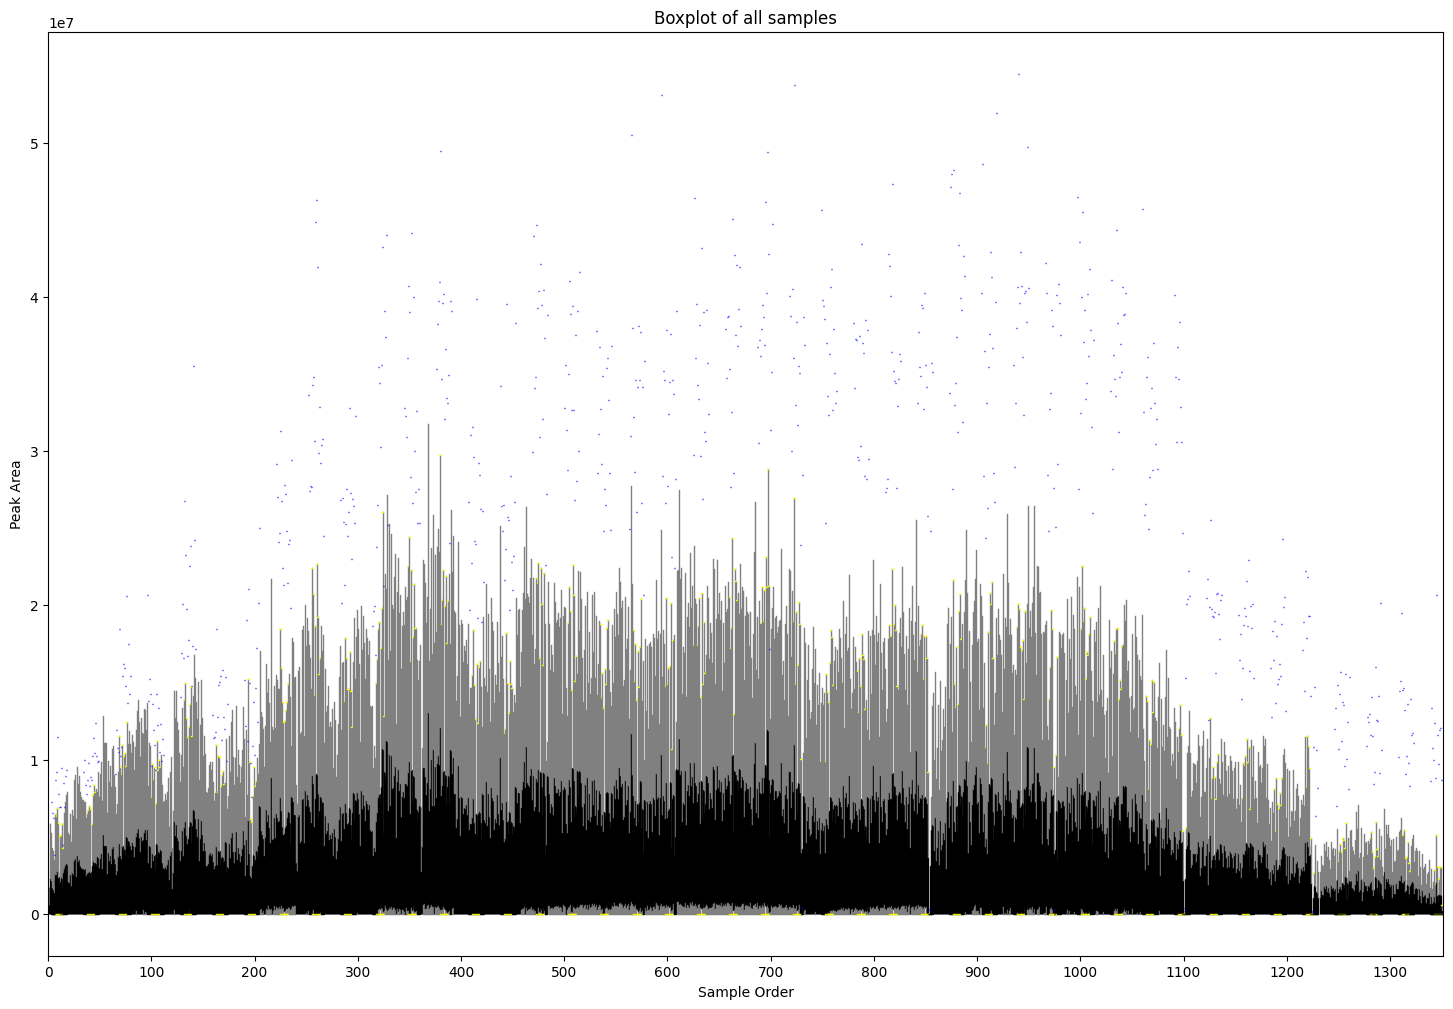

(<Figure size 1800x1200 with 1 Axes>,
 <Axes: title={'center': 'Boxplot of all samples'}, xlabel='Sample Order', ylabel='Peak Area'>)

In [249]:
def visualize_boxplot(data, is_qc_sample, sufixes = ['.png', '.pdf']):
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(18, 12))

    # Create a box plot for the specific feature
    box = plt.boxplot(data.iloc[:,1:], showfliers=False, showmeans=True, meanline=True, medianprops={'color':'black'}, meanprops={'color':'blue'}, patch_artist=True, whiskerprops=dict(color='grey'), capprops=dict(color='yellow'))
    plt.title('Boxplot of all samples')

    # Can depict if there is a problem with the data (retenion time shift too big -> re-run alignment; batch effect, etc.)

    #Color boxplots of QC samples in red and the rest in blue
    colors = ['red' if qc else 'lightblue' for qc in is_qc_sample]
    # Set the colors for the individual boxplots
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Customize the plot
    plt.xlabel('Sample Order')
    plt.ylabel('Peak Area')
    xx = np.arange(0, len(data.columns[1:])+1, 100)
    plt.xticks(xx, xx)

    # Save the plot
    plt_name = main_folder + '/figures/QC_samples_boxplot_first_view'
    for sufix in sufixes:
        plt.savefig(plt_name + sufix, bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()

    #---------------------------------------------
    #REPORTING
    text0 = 'The initial visualization of the data was created.'
    text1 = 'The boxplot of all samples was created and saved to: ' + plt_name
    report.add_together([('text', text0),
                        ('text', text1),
                        ('image', plt_name + '.png'),
                        'line'])
    
    return fig, ax


#filter our quality-control samples (QC)
QC_samples = metadata[metadata['Sample Type'] == 'Quality Control']['Sample File'].tolist()
#print(QC_samples)
print(len(QC_samples))
#QC_samples mask
is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]
#print(is_qc_sample)

visualize_boxplot(data, is_qc_sample, sufixes = sufixes)

In [250]:
# QC_samples = metadata[metadata['Coffee Brand'] == 'QC']['SampleFile'].tolist()
# # QC_samples mask
# is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

# blank_samples = metadata[metadata['Coffee Brand'] == 'Blank']['SampleFile'].tolist()
# # Blank samples mask
# is_blank = [True if col in blank_samples else False for col in data.columns[1:]]

# # Create a boolean mask for the x array
# x_mask = np.full(len(data.columns) - 1, False)
# x_mask[is_qc_sample] = True

# # Choose a compounds to plot
# indexes = [0, 1, 2, 3, 4]
# for index in indexes:
#     colors = ['red' if qc else 'grey' if blank else 'blue' for blank, qc in zip(is_blank, is_qc_sample)]
#     alphas = [0.3 if qc else 0.6 for qc in is_qc_sample]
#     # Create a zero mask (for qc samples)
#     zeros_mask = data.iloc[index, 1:][is_qc_sample] == 0
#     #qc_num_zeros = zeros_mask.sum()
#     #samples_num_zeros = (data.iloc[index, 1:] == 0).sum()
    
#     # Create a scatter plot to display the QC sample points
#     plt.scatter(range(len(data.columns) -1), data.iloc[index, 1:], color= colors, alpha=alphas, marker='o') 
#     plt.plot(np.arange(len(data.columns) - 1)[x_mask][~zeros_mask], data.iloc[index, 1:][is_qc_sample][~zeros_mask], color='black', linewidth=1)
#     plt.xticks(rotation=90)
#     plt.xlabel('Samples in order')
#     plt.ylabel('Peak Area')
#     plt.title("cpID = " + data.iloc[index, 0])
#     for sufix in sufixes:
#         plt.savefig(main_folder + '/figures/single_compound_' + str(index) + '_scatter_first_view' + sufix, dpi=300, bbox_inches='tight')
#     plt.show()

# #---------------------------------------------
# #REPORTING
# text = 'View of samples for a single compound with highlighted QC samples was created.'
# images = [main_folder + '/figures/single_compound_' + str(index) + '_scatter_first_view' for index in indexes]
# report.add_text(text)
# for image in images:
#     report.add_image(image)
# report.add_line()


### Batch visualization

[   0  337  675 1013 1351]
0


C:\Users\janna\AppData\Local\Temp\ipykernel_16556\2866429126.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


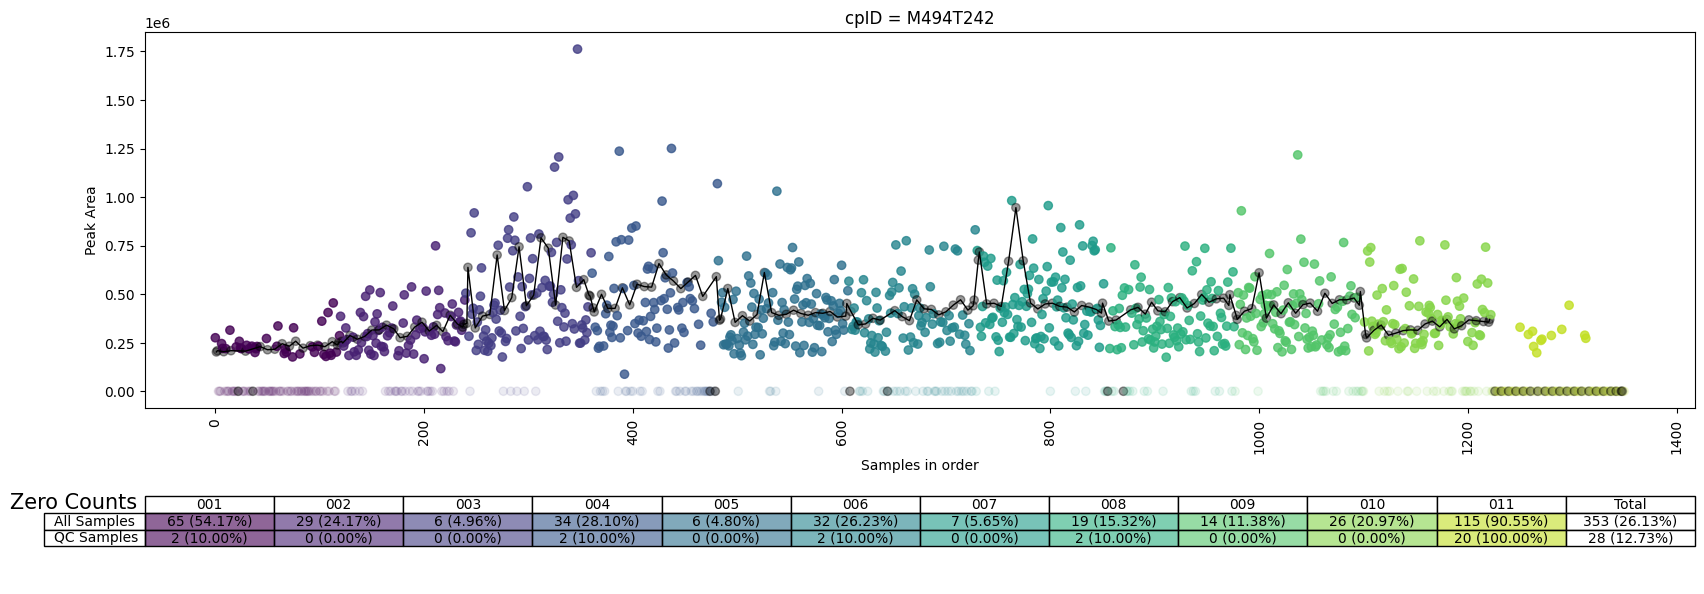

337


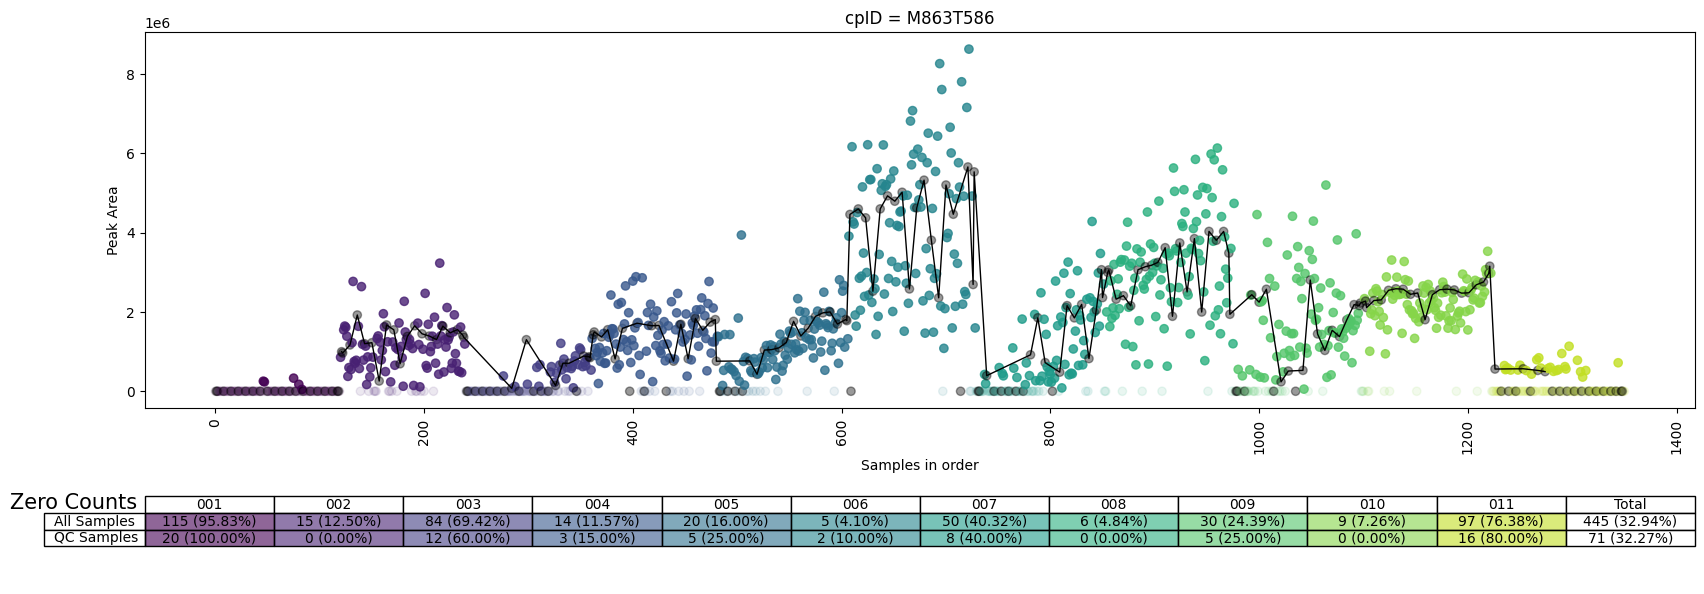

675


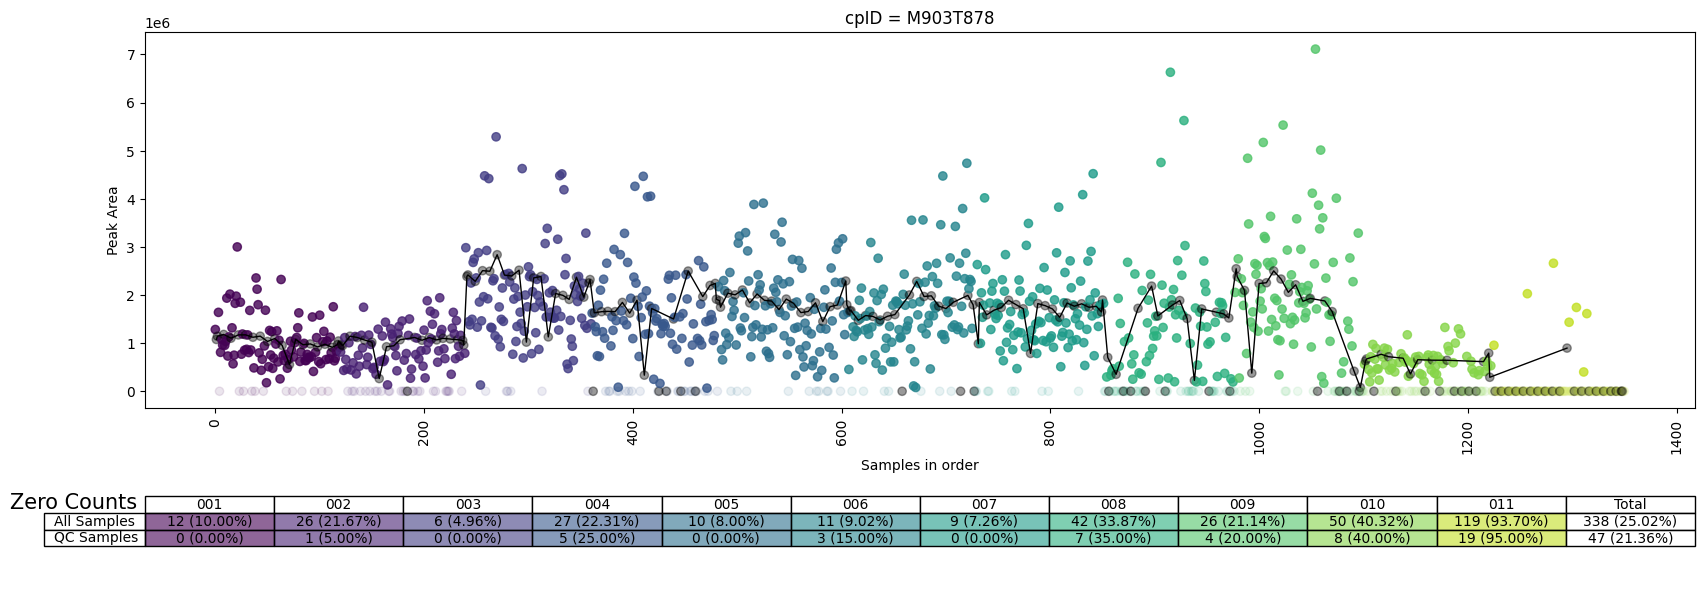

1013


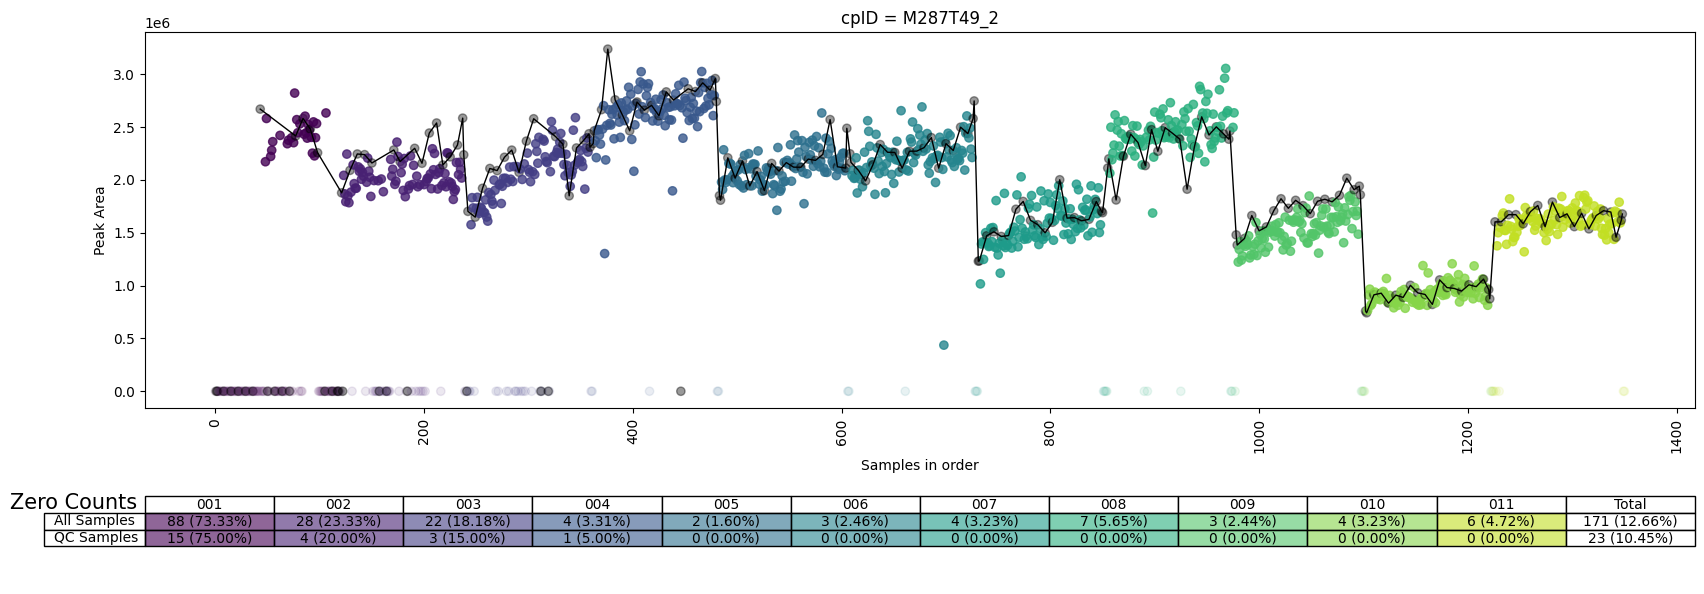

1351


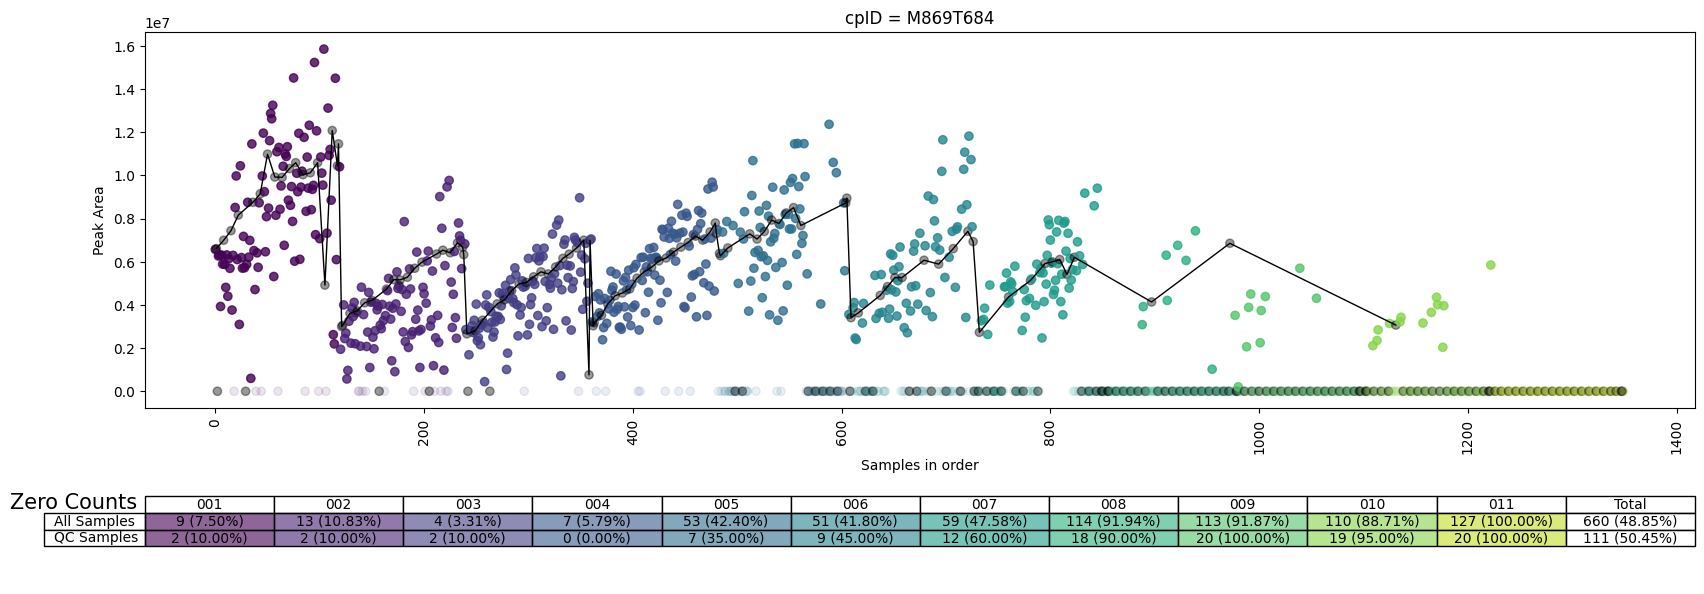

In [251]:

def visualize_by_batch(df, QC_samples, main_folder, show = 'default', sufixes = ['.png', '.pdf'], batch = None, cmap = 'viridis'):

    # If show isnt list or numpy array
    if type(show) != list and type(show) != np.ndarray: 
        if show == 'default':
            show = np.linspace(0, len(df.columns)-1, 5, dtype=int)
            print(show)
        elif show == 'all':
            show = np.arange(len(df.columns))
        elif show == 'none':
            show = []
        else:
            show = [show]

    if batch is None:
        batch = ['all_one_batch' for i in range(len(df.columns) - 1)]  # Dummy batch information (for cases where its all the same batch)

    unique_batches = []
    for b in batch:
        if b not in unique_batches:
            unique_batches.append(b)
    
    cmap = mpl.cm.get_cmap(cmap)

    # Create a dictionary that maps each unique batch to a unique index
    batch_to_index = {batch: index for index, batch in enumerate(unique_batches)}

    # Normalize the indices between 0 and 1
    normalized_indices = {batch: index / len(unique_batches) for batch, index in batch_to_index.items()}

    # Create a dictionary that maps each batch to a color
    batch_colors = [mpl.colors.rgb2hex(cmap(normalized_indices[batch])) for batch in unique_batches]

    batch_to_color = {batch_id: batch_colors[i % len(batch_colors)] for i, batch_id in enumerate(unique_batches)}

    # QC_samples mask
    is_qc_sample = [True if col in QC_samples else False for col in df.columns[1:]]
    # Create a boolean mask for the x array
    x_mask = np.full(len(df.columns) - 1, False)
    x_mask[is_qc_sample] = True

    # Color based on the batch (and if it is QC sample then always black)
    for feature in show:
        print(feature)

        # Colors and alphas and markers
        colors = ['black' if qc else batch_to_color[batch[i]] for i, qc in enumerate(is_qc_sample)]
        row_data = df.iloc[feature, 1:]
        alphas = [0.4 if qc else 0.1 if zero else 0.8 for qc, zero in zip(is_qc_sample, row_data == 0)]

        # Create a zero mask (for qc samples)
        zeros_mask = df.iloc[feature, 1:][is_qc_sample] == 0

        # Initialize a dictionary to store the zero counts for each batch
        zero_counts = {batch_id: 0 for batch_id in set(batch)}
        qc_zero_counts = {batch_id: 0 for batch_id in set(batch)}

        # Update the zero counts for each batch
        for i, (b, zero) in enumerate(zip(batch, row_data == 0)):
            if zero:
                zero_counts[b] += 1
                if is_qc_sample[i]:
                    qc_zero_counts[b] += 1
        
        # Create a gridspec object
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # 3:1 height ratio

        # Create a figure with specified size
        fig = plt.figure(figsize=(20, 4)) 

        # Create a scatter plot to display the QC sample points
        plt.subplot(gs[0])
        plt.scatter(range(len(df.columns) -1), df.iloc[feature, 1:], color= colors, alpha=alphas, marker='o') 
        plt.plot(np.arange(len(df.columns) - 1)[x_mask][~zeros_mask], df.iloc[feature, 1:][is_qc_sample][~zeros_mask], color='black', linewidth=1)
        plt.xticks(rotation=90)
        plt.xlabel('Samples in order')
        plt.ylabel('Peak Area')
        plt.title("cpID = " + df.iloc[feature, 0])

        # Create a table to display the zero counts
        plt.subplot(gs[1])
        plt.axis('tight')  # Remove axis
        plt.axis('off')  # Hide axis
        fig.subplots_adjust(bottom=-0.5) # Adjust the bottom of the figure to make room for the table

        # Calculate the total number of samples and QC samples for each batch
        total_samples = {batch_id: batch.count(batch_id) for batch_id in unique_batches}
        total_qc_samples = {batch_id: sum(1 for b, qc in zip(batch, is_qc_sample) if (b == batch_id and qc)) for batch_id in unique_batches}

        # Calculate the total number of QC samples
        total_qc_samples_count = sum(qc_zero_counts.values())
        total_qc_percentage = total_qc_samples_count / sum(is_qc_sample) * 100

        # Calculate the percentage of zeros for each batch
        zero_percentages = {batch: zero_counts[batch] / total_samples[batch] * 100 for batch in unique_batches}

        # Calculate the percentage of QC zeros for each batch
        qc_zero_percentages = {batch: qc_zero_counts[batch] / total_qc_samples[batch] * 100 if total_qc_samples[batch] > 0 else 0 for batch in unique_batches}

        # Format the zero counts and percentages as strings
        formatted_zero_counts = [f"{zero_counts[batch]} ({zero_percentages[batch]:.2f}%)" for batch in unique_batches]

        # Format the QC zero counts and percentages as strings
        formatted_qc_zero_counts = [f"{qc_zero_counts[batch]} ({qc_zero_percentages[batch]:.2f}%)" for batch in unique_batches]

        # Calculate the total number of missing values
        total_missing = sum(zero_counts.values()) 
        total_percentage = total_missing / len(batch) * 100
        
        # Append 'white' to the batch colors for the total
        table_batch_colors = batch_colors + ['white']

        # Append the total to the sorted lists
        col_labels = unique_batches + ['Total']

        # Append the total to the formatted zero counts
        formatted_zero_counts.append(f"{total_missing} ({total_percentage:.2f}%)")
        formatted_qc_zero_counts.append(f"{total_qc_samples_count} ({total_qc_percentage:.2f}%)")

        # Convert all colors in the list to RGBA format
        table_batch_colors_rgba = [convert_to_rgba(color, 0.6) for color in table_batch_colors]

        # Create the table 
        plt.table(cellText=[formatted_zero_counts, formatted_qc_zero_counts],  # Sorted values of the table
            #cellColours=[table_batch_colors, table_batch_colors],
            cellColours=[table_batch_colors_rgba, table_batch_colors_rgba], # Sorted colors of the table
            rowLabels=['All Samples', 'QC Samples'],  # Row label
            colLabels=col_labels,  # Sorted column labels
            cellLoc='center',  # Alignment of the data in the table
            fontsize=10,  # Font size
            loc='center')  # Position of the table

        # Add a text annotation for "Zero Counts"
        plt.text(x=-0.005, y=0.65, s='Zero Counts', fontsize=15, transform=plt.gca().transAxes, ha='right', va='center')

        plt_name = main_folder + '/figures/single_compound_' + str(feature) + '_batches_first_view'
        for sufix in sufixes:
            plt.savefig(plt_name + sufix, dpi=300, bbox_inches='tight')
        plt.show()

    #---------------------------------------------
    #REPORTING
    text = 'View of samples for a single compound with highlighted QC samples was created.'
    report.add_text(text)
    #add plot to the report
    images = [main_folder + '/figures/single_compound_' + str(feature) + '_batches_first_view' for feature in show]
    for image in images:
        report.add_image(image)
    report.add_pagebreak()


def convert_to_rgba(color, alpha=0.5):
    rgb = mcolors.hex2color(color)  # Convert hexadecimal to RGB
    return rgb + (alpha,)  # Concatenate RGB with alpha


# # Get batch information
batch = batch_info['Batch'].tolist()
batch = [value for value in batch if value is not None]

# or 
#batch = None # All samples in one batch

QC_samples = metadata[metadata['Sample Type'] == 'Quality Control']['Sample File'].tolist()

# Choose a compounds to plot
#show = [0, 1, 2, 3, 4]
# # add index of a feature with cpdID == M159T50_2
# coi = data[data['cpdID'] == 'M159T50_2'].index[0]
# indexes.append(coi)

visualize_by_batch(df = data, QC_samples = QC_samples, main_folder = main_folder, show = 'default', sufixes = sufixes, batch = batch, cmap = 'viridis') 

In [252]:
# Dropping columns to omit them from analysis (specifically for this dataset)

# print(data.shape)
# # Dropping blank samples (first and last)
# first_blank_values = data.iloc[:, 1]
# data = data.drop(data.columns[1], axis=1)
# last_blank_values = data.iloc[:, -1]
# data = data.drop(data.columns[-1], axis=1)
# print(data.shape)

# #Dropping first 5 (QC) samples
# data = data.drop(data.columns[1:6], axis=1)
# print(data.shape)

# #Dropping last 10 (QC) samples
# data = data.drop(data.columns[-10:], axis=1)
# print(data.shape)


# #---------------------------------------------
# #REPORTING
# text0 = 'Blank samples were removed'
# text1 = 'First 5 and last 10 QC samples were removed. (dQC)'
# report.add_together([('text', text0), 
#                      ('text', text1), 
#                      'line'])

### Blank filtering MOVED UP HERE (LOG MADE A MESS, NEED TO CONSIDER WHERE TO DO THIS)

##### Also it is important to do this by batch

In [253]:
def filter_blank_intensity_ratio(data, blank_samples, QC_samples, ratio = 20 ,setting = 'first'):
    blank_threshold = ratio
    # filter out features (compounds) with intensity sample/blank < ratio (default = 20/1)
    # filters features by comparing the intensity of blank samples to the median intensity of QC samples. Features where the relative intensity (fold change) is not large when compared to the blank are removed.

    # Blank_samples mask
    is_blank_sample = [True if col in blank_samples else False for col in data.columns[1:]]
    # QC_samples mask
    is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

    # Different approaches
    if setting == 'median':
        #Calculate intensity sample/blank by taking median value
        blank_intensities = data[data.columns[1:][is_blank_sample]].median(axis=1)
    elif setting == 'min':
        #Calculate intensity sample/blank by taking min value
       blank_intensities = data[data.columns[1:][is_blank_sample]].min(axis=1)
    elif setting == 'mean':
        #Calculate intensity sample/blank by taking mean value
        blank_intensities = data[data.columns[1:][is_blank_sample]].mean(axis=1)
    elif setting == 'first':
        #Calculate intensity sample/blank by taking the first blank as reference value
        blank_intensities = data[data.columns[1:][is_blank_sample]].iloc[:, 0]
    elif setting == 'last':
        #Calculate intensity sample/blank by taking the last blank as reference value
        blank_intensities = data[data.columns[1:][is_blank_sample]].iloc[:, -1]
    else:
        raise ValueError("Setting not recognized. Choose from: 'median', 'min', 'mean', 'first' or 'last'. (Chooses blank to use as reference value)")

    intensity_sample_blank = data[data.columns[1:][is_qc_sample]].median(axis=1)/blank_intensities
    print(intensity_sample_blank)
    
    #Filter out features (compounds) with intensity sample/blank < blank_threshold
    data = data[intensity_sample_blank >= blank_threshold]
    #reset index
    data = data.reset_index(drop=True)

    #report how many features were removed
    print("Number of features removed: " + str(len(intensity_sample_blank[intensity_sample_blank < blank_threshold])) + " ;being: " + str(intensity_sample_blank[intensity_sample_blank < blank_threshold].index.tolist()))

    #---------------------------------------------
    #REPORTING
    text0 = 'Features with intensity sample/blank < ' + str(blank_threshold) + ' were removed.'
    text1 = 'Number of features removed: ' + str(len(intensity_sample_blank[intensity_sample_blank < blank_threshold])) + ' ;being: '+ str(intensity_sample_blank[intensity_sample_blank < blank_threshold].index.tolist()[:10])[:-1] + ', ...'
    report.add_together([('text', text0),
                        ('text', text1),
                        'line'])

    return data 

blank_samples = metadata[metadata['Sample Type'] == 'Blank']['Sample File'].tolist()
QC_samples = metadata[metadata['Sample Type'] == 'Quality Control']['Sample File'].tolist()

data = filter_blank_intensity_ratio(data, blank_samples = blank_samples, QC_samples = QC_samples, ratio = 20/1, setting = 'first')
data


0       inf
1       inf
2       inf
3       inf
4       inf
       ... 
1556    inf
1557    inf
1558    inf
1559    inf
1560    inf
Length: 1561, dtype: float64
Number of features removed: 17 ;being: [27, 95, 117, 188, 195, 199, 591, 599, 747, 765, 855, 956, 1190, 1359, 1470, 1521, 1525]


,cpdID,Area: SRM_POS_B01_C30_01.raw (F491),Area: QC_POS_B01_C30_09.raw (F471),Area: QC_POS_B01_C30_10.raw (F472),Area: L2728_M_Group09_POS_B01_C30.raw (F433),Area: L2768_M_Group04_POS_B01_C30.raw (F463),Area: L2672_M_Group17_POS_B01_C30.raw (F400),Area: L2703_M_Group18_POS_B01_C30.raw (F409),Area: L2708_M_Group04_POS_B01_C30.raw (F414),Area: QC_POS_B01_C30_11.raw (F473),...,Area: L4093_M_Group13_POS_B11_C30.raw (F2930),Area: QC_POS_B11_C30_27.raw (F3012),Area: L4060_M_Group18_POS_B11_C30.raw (F2902),Area: L4043_F_Group10_POS_B11_C30.raw (F2890),Area: L4171_M_Group14_POS_B11_C30.raw (F2985),Area: L4100_M_Group12_POS_B11_C30.raw (F2937),Area: QC_POS_B11_C30_28.raw (F3013),Area: QC_POS_B11_C30_29.raw (F3014),Area: SRM_POS_B11_C30_02.raw (F3016),Area: Blank_PureIPA_POS_B11_C30_02.raw (F2888)
0,M494T242,2.756242e+05,2.024774e+05,2.091183e+05,0.000000e+00,0.000000e+00,0.0000,2.456336e+05,2.207801e+05,2.036895e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,M491T956,0.000000e+00,6.382289e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,8.236538e+05,1.152931e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,M695T943,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,M559T824,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,162957.7589,0.000000e+00,2.290414e+05,1.488975e+05,...,1.363349e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.462588e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,M813T483,1.702253e+05,5.664664e+05,4.950384e+05,5.878226e+05,0.000000e+00,435382.0448,1.423696e+06,0.000000e+00,4.866856e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,M496T165_2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,1.060187e+09,0.000000e+00,0.000000e+00,...,4.372395e+08,5.388569e+08,3.839635e+08,6.295439e+08,5.237022e+08,5.017952e+08,5.177799e+08,5.422792e+08,9.526329e+08,0.0
1514,M785T588,0.000000e+00,7.002692e+07,6.628982e+07,0.000000e+00,0.000000e+00,0.0000,6.505092e+08,4.622123e+07,9.034096e+08,...,1.987708e+08,3.589476e+08,2.186057e+08,6.764739e+08,3.991374e+08,2.288148e+08,3.612026e+08,3.691561e+08,3.136155e+08,0.0
1515,M811T683,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,4.704038e+07,...,1.911031e+08,2.628378e+08,3.402853e+08,1.382982e+09,1.895678e+08,3.368342e+08,2.096989e+08,0.000000e+00,9.304066e+08,0.0
1516,M783T536_1,1.688394e+09,1.925835e+09,1.891928e+09,1.618310e+09,1.602539e+09,0.0000,1.812430e+09,1.483689e+09,1.845386e+09,...,0.000000e+00,0.000000e+00,4.400910e+07,0.000000e+00,0.000000e+00,4.003329e+07,8.895783e+08,0.000000e+00,0.000000e+00,0.0


### QC and Batch corrections

C:\Users\janna\AppData\Local\Temp\ipykernel_16556\1804522513.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


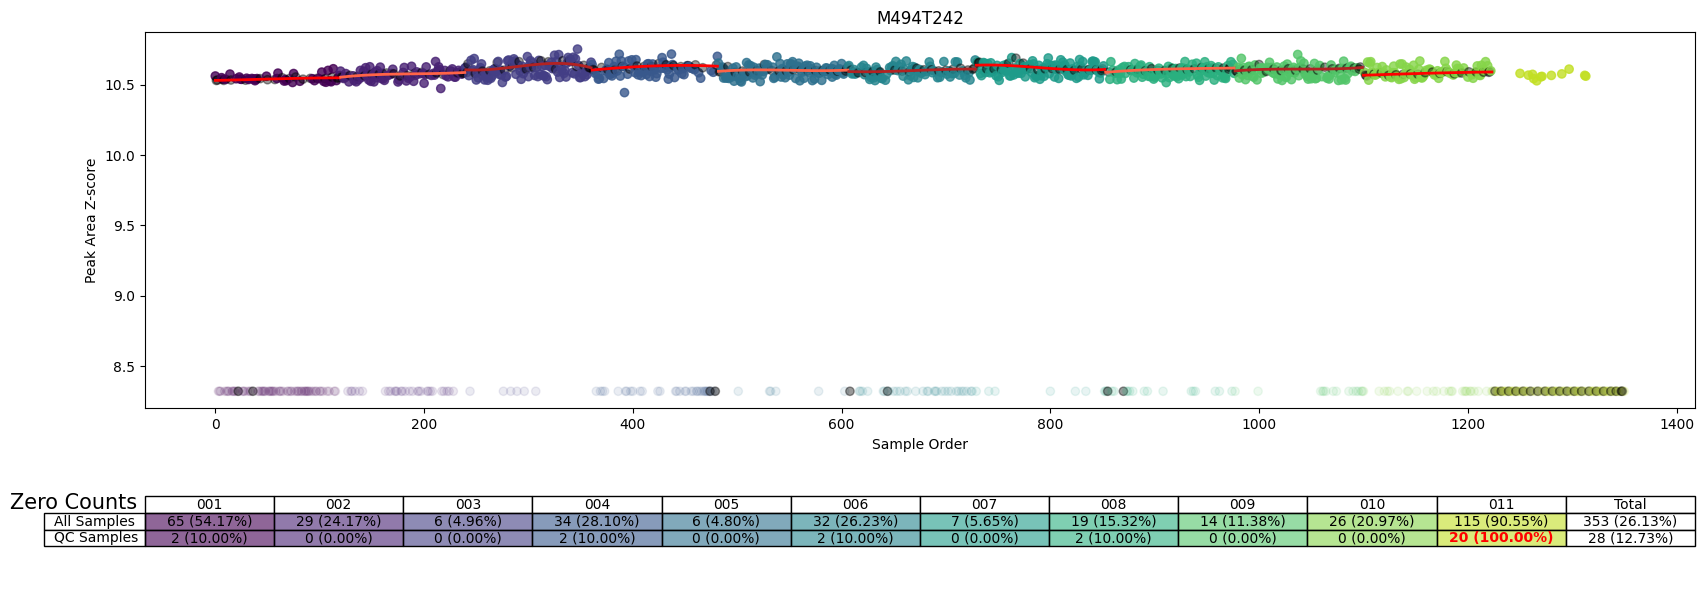

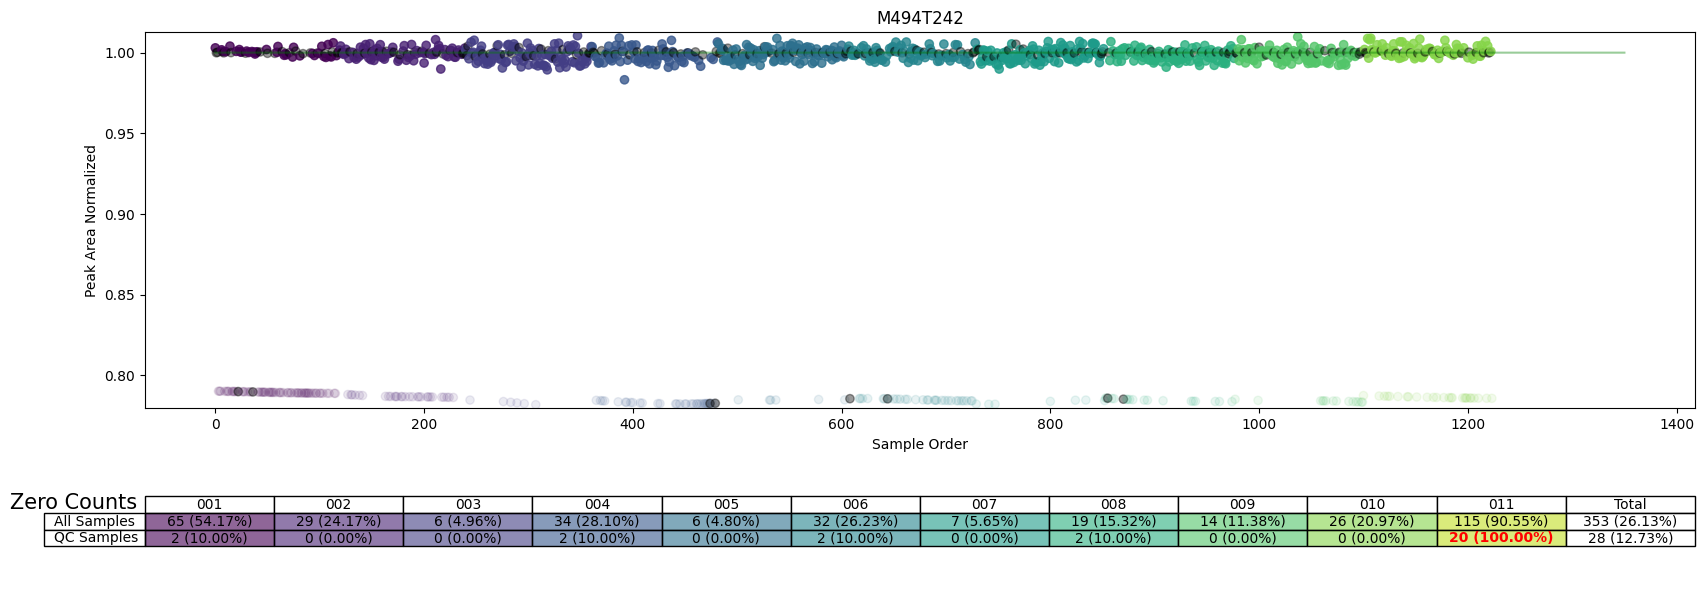

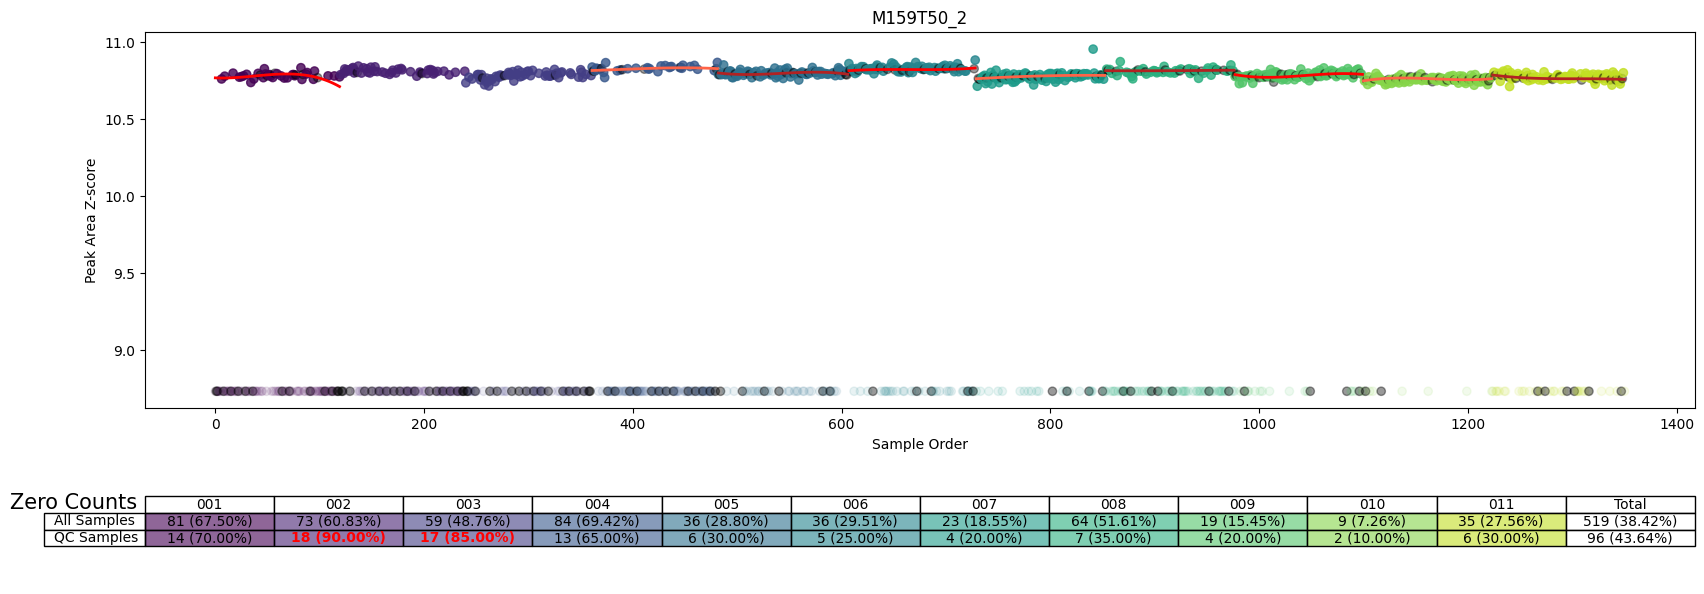

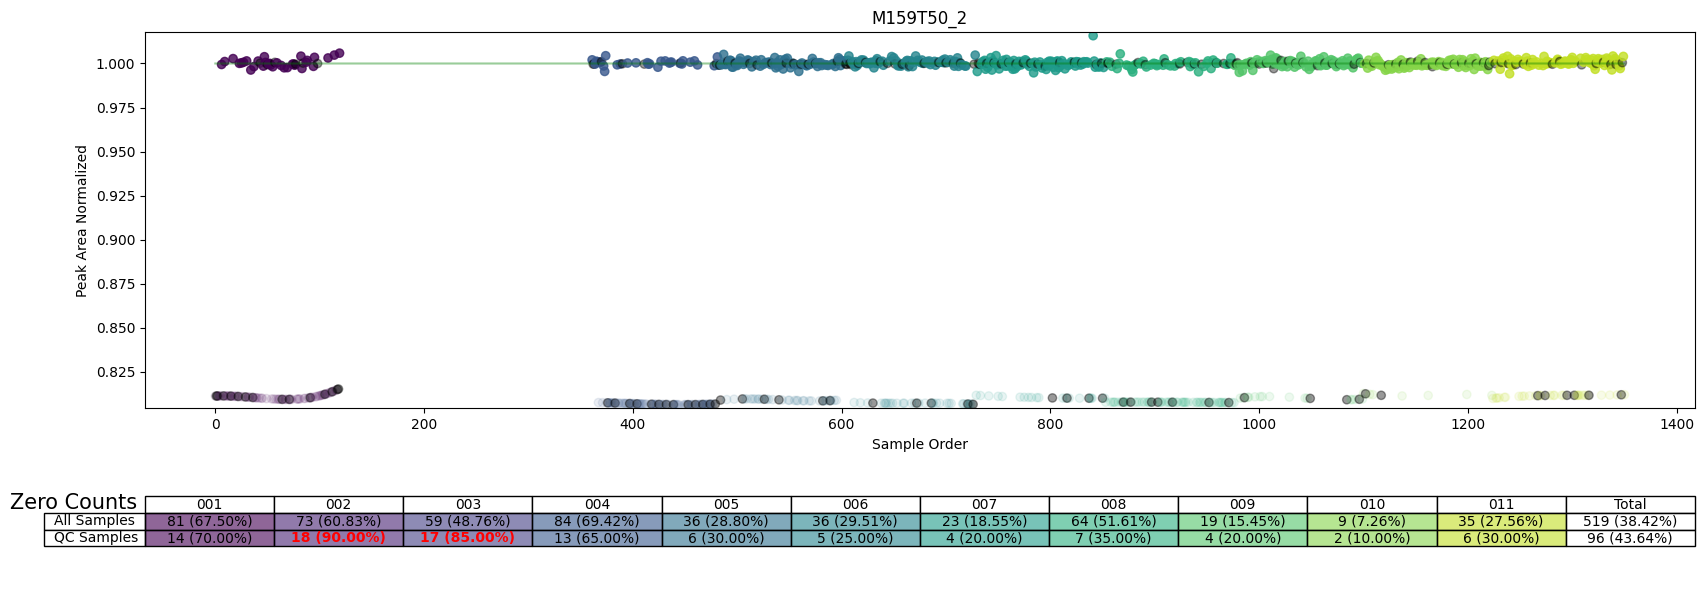

In [254]:
# Kirwan JA, Broadhurst DI, Davidson RL, Viant MR. Characterising and correcting batch variation in an automated direct infusion mass spectrometry (DIMS) metabolomics workflow. Anal Bioanal Chem. 2013 Jun;405(15):5147-57. doi: 10.1007/s00216-013-6856-7. Epub 2013 Mar 1. Erratum in: Anal Bioanal Chem. 2014 Sep;406(24):6075-6. PMID: 23455646.
# DOI 10.1007/s00216-013-6856-7

def log_transformation(df, invert=False):
    if invert:
        return np.exp(df)
    return np.log(df + 0.0001) # Add a small number to avoid log(0) 

def cubic_spline_smoothing(x, y, p, use_norm = True): #if normalization is used, then y is already z-scores
    # Fit a cubic spline to the data
    if use_norm: # Data is already normalized (it is z_scores)
        weights = 1 / (1 + (y - 10)** 2) # 10 is added in normalization
        s = UnivariateSpline(x, y, w = weights, s=p)
    else:
        zscores = zscore(y, axis=0) 
        weights = 1 / (1 + (zscores ** 2))
        s = UnivariateSpline(x, y, w = weights, s=p)   
    return s

def normalize_zscores(data):
    # Calculate the z-scores for the data
    zscores = zscore(data, axis=0) + 10 # Add 10 to avoid division by zero (or close to zero)
    
    # Return the z-scores
    return zscores, zscores.mean(axis=0), zscores.std(axis=0)

def invert_zscores(zscores, mean, std):
    # Invert the z-scores
    mean = mean.to_numpy()
    std = std.to_numpy()

    data = (zscores - 1) * std + mean # Subtract 1 (10 was added, but then it was divided in the correction step)
    
    # Return the inverted z-scores
    return data   

def leave_one_out_cross_validation(x, y, p_values, use_norm = True):
    # Initialize leave-one-out cross validation
    loo = LeaveOneOut()
    
    # Initialize the best smoothing parameter and the minimum mean squared error
    best_p = None
    min_mse = np.inf
    
    # For each smoothing parameter
    for p in p_values:
        # Initialize the mean squared error
        mse = 0
        
        # For each training set and test set
        for train_index, test_index in loo.split(x):
            # Split the data into a training set and a test set
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Fit a cubic spline to the training set
            s = cubic_spline_smoothing(x_train, y_train, p, use_norm)
            
            # Calculate the mean squared error on the test set
            mse += ((s(x_test) - y_test) ** 2).sum()
        
        # Calculate the mean squared error
        mse /= len(x)
        
        # If this is the best smoothing parameter so far, update the best smoothing parameter and the minimum mean squared error
        if mse < min_mse:
            best_p = p
            min_mse = mse
    # Return the best smoothing parameter
    return best_p

def custom_k_fold_cross_validation(x, y, p_values, k = 3, use_norm = True, min = 5, minloo = 5): #We use 5 as minloo; cubic_spline requires atleast 4 data-points to fit a cubic spline (degree 3), and one is left out (hence we use 5), can be lowered, but then we should use lesser degree spline
    # Initialize the best smoothing parameter and the minimum mean squared error
    best_p = None
    min_mse = np.inf

    # If there would be less data points then the minimum parameter, decrease the k until it works 
    while len(x)/k < min:
        k -= 1
        if k == 0:
            break
    if k <= 1:
        #Leave one out cross validation
        if len(x) < minloo:
            # Not enough data for leave-one-out cross validation
            return None
        else:
            return leave_one_out_cross_validation(x, y, p_values, use_norm)

    # For each smoothing parameter
    for p in p_values:
        # Initialize the mean squared error
        mse = 0
        
        # For each fold
        for i in range(k):

            # Split the data into a training set and a test set
            test_indices = np.arange(i, len(x), k)

            x_test = x[test_indices]
            y_test = y[test_indices]

            x_train = np.delete(x, test_indices)
            y_train = np.delete(y, test_indices)

            # Fit a cubic spline to the training set
            s = cubic_spline_smoothing(x_train, y_train, p, use_norm)

            # Calculate the mean squared error on the test set
            mse += ((s(x_test) - y_test) ** 2).sum()

        # Calculate the mean squared error
        mse /= len(x)

        # If this is the best smoothing parameter so far, update the best smoothing parameter and the minimum mean squared error
        if mse < min_mse:
            best_p = p
            min_mse = mse
    # Return the best smoothing parameter
    return best_p


def qc_correction(df, QC_samples, batch = None, p_values = 'default', show = 'default', use_log = True, use_norm = True, use_zeros = False, cmap  = 'viridis'):

    # If show isnt list or numpy array
    if type(show) != list and type(show) != np.ndarray: 
        if show == 'default':
            show = np.linspace(0, len(df.columns)-1, 5, dtype=int)
        elif show == 'all':
            show = np.arange(len(df.columns))
        elif show == 'none':
            show = []
        else:
            show = [show]

    # Find zeros in the data (if needed)
    if not use_zeros:
        # Mask for zeros
        is_zero = df == 0
        is_zero = is_zero.T # Transpose the mask to match the data

    feature_names = df.iloc[:, 0]
    # Transpose the dataframe
    df = df.iloc[:, 1:].copy()
    df = df.T

    #QC_samples
    is_qc_sample = [True if col in QC_samples else False for col in df.index]

    cmap = mpl.cm.get_cmap(cmap)   

    if batch is None:
        batch = ['all_one_batch' for i in range(len(df.index))] # Dummy batch information (for cases where its all the same batch) (not columns because of the transposition)
    
    if p_values != 'default':
        p_values_to_use = p_values

    # Batch information
    unique_batches = []
    for b in batch:
        if b not in unique_batches:
            unique_batches.append(b)
    
    # Create a dictionary that maps each unique batch to a unique index
    batch_to_index = {batch: index for index, batch in enumerate(unique_batches)}

    # Normalize the indices between 0 and 1
    normalized_indices = {batch: index / len(unique_batches) for batch, index in batch_to_index.items()}

    # Create a dictionary that maps each batch to a color
    batch_colors = [mpl.colors.rgb2hex(cmap(normalized_indices[batch])) for batch in unique_batches]

    batch_to_color = {batch_id: batch_colors[i % len(batch_colors)] for i, batch_id in enumerate(unique_batches)}

    # Colors and alphas and markers
    colors = ['black' if qc else batch_to_color[batch[i]] for i, qc in enumerate(is_qc_sample)]

    if use_log:
        # Apply log transformation to the data
        df = log_transformation(df)
    
    if use_norm:
        df, mean, std = normalize_zscores(df)

    start_time = time.time()

    # Create lists to store the plot names to plot into REPORT
    plot_names_orig = []
    plot_names_corr = []
    
    # For each feature
    chosen_p_values = []
    numbers_of_correctable_batches = []
    for feature in df.columns:
        # Iterate over batches
        splines = []
        is_correctable_batch = []
        number_of_correctable_batches = 0
        for batch_index, batch_name in enumerate(unique_batches):

            # This batch mask
            is_batch = [True if b == batch_name else False for b in batch]
            
            # Get the QC data mask
            qc_indexes = df.index.isin(QC_samples)

            if not use_zeros:
                # Use is_zero mask for this feature
                new_zero_value = df[is_zero][feature].max()

                # Mask for zeros
                isnt_zero = df[feature] > new_zero_value

                # Combine the masks
                qc_indexes = qc_indexes & isnt_zero

            #Combine the masks
            qc_indexes_batched = qc_indexes & is_batch

            qc_data = df[qc_indexes_batched] 

            x = np.arange(len(df))[qc_indexes_batched]
            y = qc_data[feature].values

            #Citation: "Recommended values of s depend on the weights, w. If the weights represent the inverse of the standard-deviation of y, then a good s value should be found in the range (m-sqrt(2*m),m+sqrt(2*m)) where m is the number of datapoints in x, y, and w." (standard-deviation is wrong tho, that doesn't work for each datapoint...) 
            if p_values == 'default':
                m = len(qc_data)
                p_values_to_use = np.linspace(m-math.sqrt(2*m), m+math.sqrt(2*m), 10)

            # Fit a cubic spline to the QC data
            p = custom_k_fold_cross_validation(x, y, p_values_to_use, 5, use_norm)
            chosen_p_values.append(p)
            if p is None:
                # This batch doesn't have enough data (might be due to filtering out zeros)
                s = None
                is_correctable_batch.append(False)
            else:
                s = cubic_spline_smoothing(x, y, p, use_norm)
                is_correctable_batch.append(True)
                number_of_correctable_batches += 1
            splines.append(s)

            #Print out progress
            percentage_done = round((feature + 1) / len(df.columns) * 100, 3)
            print(f'Progress: {percentage_done}%; last chosen p: {p}. Time estimate: {round((time.time() - start_time) / (feature + 1) * (len(df.columns) - feature - 1)/60, 2)}m       ', end='\r')

        numbers_of_correctable_batches.append(number_of_correctable_batches)        

        x = np.arange(len(df))
        y = df[feature].values

        reds = cycle(['red', 'tomato', 'firebrick'])

        # Plot the original QC data and the fitted spline
        if feature in show:
            
            # Colors and alphas and markers
            colors = ['black' if qc else batch_to_color[batch[i]] for i, qc in enumerate(is_qc_sample)]
            row_data = data.iloc[feature, 1:]
            alphas = [0.4 if qc else 0.1 if zero else 0.8 for qc, zero in zip(is_qc_sample, row_data == 0)]

            
            # Initialize a dictionary to store the zero counts for each batch
            zero_counts = {batch_id: 0 for batch_id in set(batch)}
            qc_zero_counts = {batch_id: 0 for batch_id in set(batch)}

            # Update the zero counts for each batch
            for i, (b, zero) in enumerate(zip(batch, row_data == 0)):
                if zero:
                    zero_counts[b] += 1
                    if is_qc_sample[i]:
                        qc_zero_counts[b] += 1

            # Create a gridspec object
            gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # 3:1 height ratio
            fig = plt.figure(figsize=(20, 4))

            plt.subplot(gs[0])
            plt.scatter(x, y, color = colors, alpha = alphas)
            for batch_index, batch_name in enumerate(unique_batches):
                is_batch = [True if b == batch_name else False for b in batch]
                x = np.arange(len(df))[is_batch]
                spline = splines[batch_index]
                if spline != None: # None means that there wasn't enough data for this batch
                    plt.plot(x, spline(x), color=next(reds), linewidth = 2) # Plot the fitted spline (only its relevant part)

            plt.xlabel('Sample Order')
            plt.ylabel('Peak Area Z-score')
            if len(feature_names) > 0:
                plt.title(feature_names[feature])
            else:
                plt.title(f'Feature: {feature}')

            # Create a table to display the zero counts
            plt.subplot(gs[1])
            plt.axis('tight')  # Remove axis
            plt.axis('off')  # Hide axis
            fig.subplots_adjust(bottom=-0.5) # Adjust the bottom of the figure to make room for the table

            # Calculate the total number of samples and QC samples for each batch
            total_samples = {batch_id: batch.count(batch_id) for batch_id in unique_batches}
            total_qc_samples = {batch_id: sum(1 for b, qc in zip(batch, is_qc_sample) if (b == batch_id and qc)) for batch_id in unique_batches}

            # Calculate the total number of QC samples
            total_qc_samples_count = sum(qc_zero_counts.values())
            total_qc_percentage = total_qc_samples_count / sum(is_qc_sample) * 100

            # Calculate the percentage of zeros for each batch
            zero_percentages = {batch: zero_counts[batch] / total_samples[batch] * 100 for batch in unique_batches}

            # Calculate the percentage of QC zeros for each batch
            qc_zero_percentages = {batch: qc_zero_counts[batch] / total_qc_samples[batch] * 100 if total_qc_samples[batch] > 0 else 0 for batch in unique_batches}

            # Format the zero counts and percentages as strings
            formatted_zero_counts = [f"{zero_counts[batch]} ({zero_percentages[batch]:.2f}%)" for batch in unique_batches]

            # Format the QC zero counts and percentages as strings
            formatted_qc_zero_counts = [f"{qc_zero_counts[batch]} ({qc_zero_percentages[batch]:.2f}%)" for batch in unique_batches]

            # Calculate the total number of missing values
            total_missing = sum(zero_counts.values()) 
            total_percentage = total_missing / len(batch) * 100
            
            # Append 'white' to the batch colors for the total
            table_batch_colors = batch_colors + ['white']

            # Append the total to the sorted lists
            col_labels = unique_batches + ['Total']

            # Append the total to the formatted zero counts
            formatted_zero_counts.append(f"{total_missing} ({total_percentage:.2f}%)")
            formatted_qc_zero_counts.append(f"{total_qc_samples_count} ({total_qc_percentage:.2f}%)")

            # Convert all colors in the list to RGBA format
            table_batch_colors_rgba = [convert_to_rgba(color, 0.6) for color in table_batch_colors]

            # Create the table 
            table = plt.table(cellText=[formatted_zero_counts, formatted_qc_zero_counts],  # Sorted values of the table
                #cellColours=[table_batch_colors, table_batch_colors],
                cellColours=[table_batch_colors_rgba, table_batch_colors_rgba], # Sorted colors of the table
                rowLabels=['All Samples', 'QC Samples'],  # Row label
                colLabels=col_labels,  # Sorted column labels
                cellLoc='center',  # Alignment of the data in the table
                fontsize=10,  # Font size
                loc='center')  # Position of the table
            
            # Change color of text in cells of uncorrectable batches
            cells_to_change_color = [(2, i) for i, correctable in enumerate(is_correctable_batch) if not correctable]
            for cell in cells_to_change_color:
                table.get_celld()[cell].set_text_props(fontweight='bold', color='red') # Set the text to bold and red if the batch wasn't correctable

            # Add a text annotation for "Zero Counts"
            plt.text(x=-0.005, y=0.65, s='Zero Counts', fontsize=15, transform=plt.gca().transAxes, ha='right', va='center')

            #Save the plot
            for sufix in sufixes:
                plt_name = main_folder + '/figures/QC_correction_' + str(feature) + '_original'
                plt.savefig(plt_name + sufix, dpi=300, bbox_inches='tight')
            plot_names_orig.append(plt_name +'.png')
            plt.show()

        #CORRECTION of the data for the feature BATCH by BATCH
        for batch_index, batch_name in enumerate(unique_batches):
            #This batch mask
            is_batch = [True if b == batch_name else False for b in batch]
            # Use fitted spline to correct all the data for the feature batch by batch
            x = np.arange(len(df[feature]))
            if splines[batch_index] is not None: # None means that there wasn't enough data for this batch
                df[feature][is_batch] = df[feature][is_batch] / abs(splines[batch_index](x[is_batch])) # !! the order of things matter a lot here; to only use relevant parts of the spline !!
            else:
                df[feature][is_batch] = [0 for i in df[feature][is_batch]] # If there wasn't enough data, then just set the values to 0

        # Plot the corrected data
        if feature in show: 
            # Create a gridspec object
            gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # 3:1 height ratio
            fig = plt.figure(figsize=(20, 4))

            plt.subplot(gs[0])
            plt.scatter(x, y, color = colors, alpha = alphas)
            plt.plot(x, [1 for i in range(len(x))], color='green', label='mean', alpha = 0.4)

            # Calculate min and max values for the y axis (excluding zeros)

            y_min = df[feature][df[feature] != 0].min()
            y_max = df[feature].max()
            offset = 0.01 * (y_max - y_min) # 1% of the range
            plt.ylim(y_min - offset, y_max + offset) # Set the y axis limits (no interpolation = zeros - are not shown)

            plt.xlabel('Sample Order')
            plt.ylabel('Peak Area Normalized')
            if len(feature_names) > 0:
                plt.title(feature_names[feature])
            else:
                plt.title(f'Feature: {feature}')

            # Create a table to display the zero counts
            plt.subplot(gs[1])
            plt.axis('tight')  # Remove axis
            plt.axis('off')  # Hide axis
            fig.subplots_adjust(bottom=-0.5) # Adjust the bottom of the figure to make room for the table
            
            # Create the table 
            table = plt.table(cellText=[formatted_zero_counts, formatted_qc_zero_counts],  # Sorted values of the table
                #cellColours=[table_batch_colors, table_batch_colors],
                cellColours=[table_batch_colors_rgba, table_batch_colors_rgba], # Sorted colors of the table
                rowLabels=['All Samples', 'QC Samples'],  # Row label
                colLabels=col_labels,  # Sorted column labels
                cellLoc='center',  # Alignment of the data in the table
                fontsize=10,  # Font size
                loc='center') # Position of the table
                
            # Change color of text in cells of uncorrectable batches
            cells_to_change_color = [(2, i) for i, correctable in enumerate(is_correctable_batch) if not correctable]
            for cell in cells_to_change_color:
                table.get_celld()[cell].set_text_props(fontweight='bold', color='red') # Set the text to bold and red if the batch wasn't correctable

            # Add a text annotation for "Zero Counts"
            plt.text(x=-0.005, y=0.65, s='Zero Counts', fontsize=15, transform=plt.gca().transAxes, ha='right', va='center')

            
            #Save the plot
            for sufix in sufixes:
                plt_name = main_folder + '/figures/QC_correction_' + str(feature) + '_corrected'
                plt.savefig(plt_name + sufix, dpi=300, bbox_inches='tight')
            plot_names_orig.append(plt_name +'.png')
            plt.show()

    # Create a dictionary with the chosen p values
    chosen_p_values = pd.Series(chosen_p_values).value_counts().to_dict()
    # Sort the dictionary by the number of occurrences
    chosen_p_values = {k: v for k, v in sorted(chosen_p_values.items(), key=lambda item: item[1], reverse=True)}


    if use_norm:
        # Calculate new std
        #std_new = df.std(axis=0)

        # Invert the normalization (based on the old mean and the new std (is it good or bad?)) 
        df = invert_zscores(df, mean, std)

    if use_log:
        # Invert the log transformation
        df= log_transformation(df, invert=True)


    # Transpose the dataframe back    
    df = df.T
    # Add cpdID as a first column (back)
    df.insert(0, 'cpdID', feature_names)
    
    df['corrected_batches'] = numbers_of_correctable_batches

    #---------------------------------------------
    #REPORTING 1
    text0 = 'QC correction was performed.'
    texts = []
    text1 = 'In the correction process, the data ' + ('WAS' if use_log else "WASN'T") + ' log-transformed and ' + ('WAS' if use_norm else "WASN'T") +' normalized.'
    texts.append(('text', text1, 'italic'))
    if use_log or use_norm:
        text2 = 'This step was then inverted after the correction.'
        texts.append(('text', text2, 'italic'))
    text3 = "The smoothing parameter was optimized using variation of k-fold cross-validation from a range defined as <m-math.sqrt(2*m), m+math.sqrt(2*m)>. which was: <"+ str(int(m-math.sqrt(2*m))) + "; " + str(int(m+math.sqrt(2*m))) + ">; where m is the amount of data-points interpolated (in this case the number of QCs)"
    texts.append(('text', text3))
    together = [('text', text0, 'bold')]
    together.extend(texts)
    report.add_together(together)
    report.add_line()
    for plot_names in zip(plot_names_orig, plot_names_corr):
        report.add_together([('text', 'Original data:', 'bold'),
                            ('image', plot_names[0]),
                            ('text', 'Corrected data:', 'bold'),
                            ('image', plot_names[1]),
                            'line'])
    return df


#---------------------------------------------
QC_samples = metadata[metadata['Sample Type'] == 'Quality Control']['Sample File'].tolist()

# BATCH INFORMATION
# # Get batch information
#
batch = batch_info['Batch'].tolist()
batch = [value for value in batch if value is not None]
# or
# # for testing purposes lets separate the data into 2 batches half and half
# batch = ['batch1' for i in range(len(df.columns))]
# batch[int(len(df.columns)/2):] = ['batch2' for i in range(len(df.columns) - int(len(df.columns)/2))]
# or 
#batch = None # All samples in one batch

data = qc_correction(data, QC_samples, batch = batch, p_values = 'default', show = 'default', use_log = True, use_norm = True, use_zeros = False)

print()
print('Done')

#---------------------------------------------
#REPORTING 2
report.add_pagebreak()


In [ ]:
data

,cpdID,Area: SRM_POS_B01_C30_01.raw (F491),Area: QC_POS_B01_C30_09.raw (F471),Area: QC_POS_B01_C30_10.raw (F472),Area: L2728_M_Group09_POS_B01_C30.raw (F433),Area: L2768_M_Group04_POS_B01_C30.raw (F463),Area: L2672_M_Group17_POS_B01_C30.raw (F400),Area: L2703_M_Group18_POS_B01_C30.raw (F409),Area: L2708_M_Group04_POS_B01_C30.raw (F414),Area: QC_POS_B01_C30_11.raw (F473),...,Area: L4093_M_Group13_POS_B11_C30.raw (F2930),Area: QC_POS_B11_C30_27.raw (F3012),Area: L4060_M_Group18_POS_B11_C30.raw (F2902),Area: L4043_F_Group10_POS_B11_C30.raw (F2890),Area: L4171_M_Group14_POS_B11_C30.raw (F2985),Area: L4100_M_Group12_POS_B11_C30.raw (F2937),Area: QC_POS_B11_C30_28.raw (F3013),Area: QC_POS_B11_C30_29.raw (F3014),Area: SRM_POS_B11_C30_02.raw (F3016),Area: Blank_PureIPA_POS_B11_C30_02.raw (F2888)
0,M494T242,22092.009603,22025.042093,22031.691075,17853.533996,17853.324792,17853.112342,22065.137837,22041.747621,22024.009751,...,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896
1,M491T956,18230.002517,21964.050221,18240.561405,18245.504502,18250.228461,18254.737156,18259.034502,22051.498081,22118.623227,...,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896
2,M695T943,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,...,17759.544673,17761.887221,17764.269990,17766.693365,17769.157735,17771.663490,17774.211022,17776.800723,17779.432989,17782.108217
3,M559T824,18464.106214,18460.867294,18457.737347,18454.714286,18451.796032,22050.018664,18446.265692,22105.409149,22021.902523,...,21867.296544,18053.221193,18043.113499,18032.745462,18022.115164,21802.092554,18000.060449,17988.632531,17976.935353,17964.967339
4,M813T483,21793.576373,22056.058669,22014.875652,22044.030805,17458.983685,21956.813316,22218.450309,17442.727628,21956.588576,...,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896,8100.083896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,M496T165_2,12988.132376,12987.618565,12987.116009,12986.624598,12986.144225,12985.674782,22027.861537,12984.768260,12984.330966,...,21939.547806,22022.355756,21890.597378,22085.366509,22013.920884,21998.077546,22011.308943,22030.393440,22253.831102,13059.896632
1514,M785T588,15457.678235,21937.061448,21921.993345,15458.187457,15457.900949,15457.394762,22570.385518,21815.350057,22660.885605,...,21852.112989,22017.926833,21882.895618,22199.406563,22054.495368,21902.565784,22031.577361,22040.114637,21997.295362,15297.741392
1515,M811T683,16522.982976,16515.243643,16507.497829,16499.749045,16492.000778,16484.256489,16476.519615,16468.793569,22129.795775,...,21905.539318,21988.149090,22057.066484,22400.195321,21935.262620,22079.955722,21976.650051,16200.557363,22351.153849,16210.484162
1516,M783T536_1,22077.061015,22109.560172,22110.279668,22081.499192,22083.322026,16519.802224,22116.263295,22077.087297,22125.972321,...,16519.369617,16526.077724,21365.130184,16541.130855,16549.502737,21389.866766,22052.855793,16578.167244,16588.953542,16600.380738


### RSD% Filter on QC samples

1352
(724, 1353)
1352


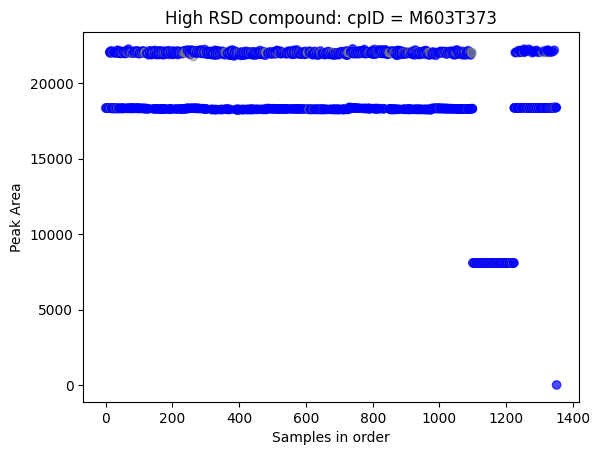

<Figure size 640x480 with 0 Axes>

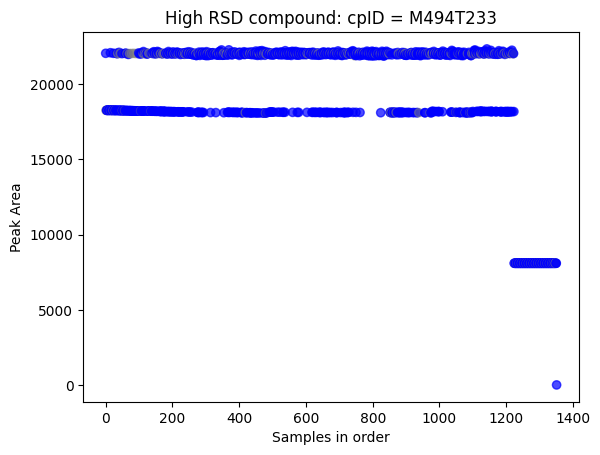

<Figure size 640x480 with 0 Axes>

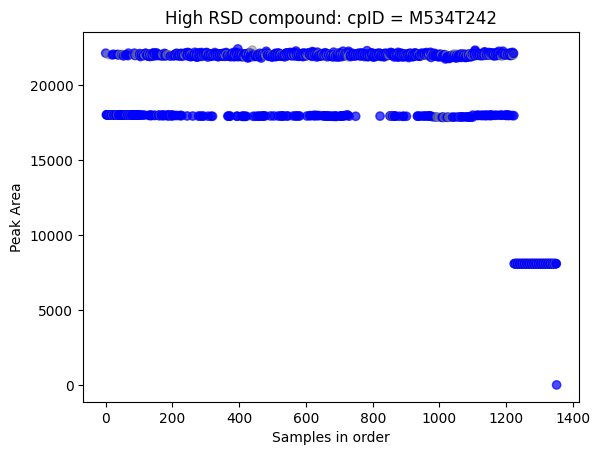

<Figure size 640x480 with 0 Axes>

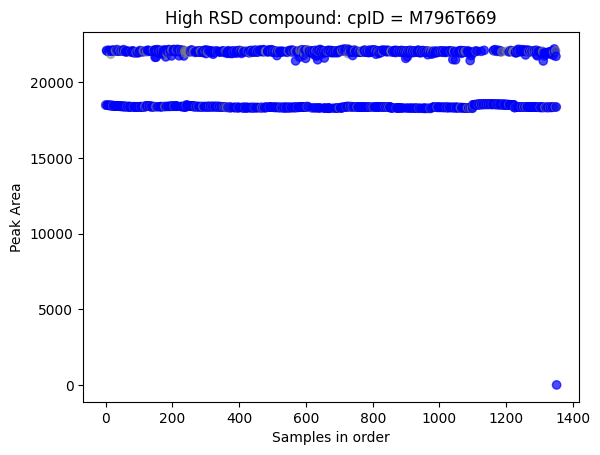

<Figure size 640x480 with 0 Axes>

Number of features removed: 794 ;being: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 34, 35, 36, 37, 38, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 96, 97, 98, 99, 100, 104, 107, 108, 109, 110, 111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 125, 127, 128, 129, 130, 131, 134, 136, 140, 147, 149, 150, 151, 152, 157, 159, 161, 162, 163, 165, 166, 169, 170, 171, 174, 175, 176, 178, 179, 180, 182, 185, 186, 187, 189, 192, 194, 196, 201, 202, 203, 207, 208, 209, 210, 211, 215, 216, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 232, 233, 235, 236, 237, 238, 239, 240, 242, 244, 246, 247, 248, 249, 250, 251, 254, 255, 256, 257, 258, 259, 260, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 278, 281, 282, 283, 285, 286, 289, 290, 293, 294, 295, 296, 297, 298, 299, 301, 302, 304, 30

In [ ]:
#WHEN TO DO THIS? BEFORE OR AFTER DATA TRANSFORMATION?
#calculate before and after batch correction (but filter after)
#if one compound is unstable and has high rsd for QC, then this compound is ommited from the analysis
#QC RSD% > 20% removed

def filter_rsd(data, QC_samples, rsd_threshold = 20):

    #QC_samples mask
    is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

    #Calculate RSD for only QC samples
    qc_rsd = data[data.columns[1:][is_qc_sample]].std(axis=1)/data[data.columns[1:][is_qc_sample]].mean(axis=1)*100

    #Add RSD into the data
    data['QC_RSD'] = qc_rsd

    #Filter out features (compounds) with RSD > rsd_threshold
    data = data[data['QC_RSD'] <= rsd_threshold]
    print(data.shape)

    #Plot some of the compounds with high RSD
    number_plotted = 4
    indexes = qc_rsd[qc_rsd > rsd_threshold].index.tolist()[:number_plotted]
    if len(indexes) < number_plotted:
        number_plotted = len(indexes)
    if len(indexes)  == 0:
        print("No compounds with RSD > " + str(rsd_threshold) + " were found.")
    else:   
        alphas = [0.5 if qc else 0.7 for qc in is_qc_sample]
        colors = ['grey' if qc else 'blue' for qc in is_qc_sample]
        for i in range(number_plotted):
            plt.scatter(range(len(data.columns[1:])), data.iloc[indexes[i],1:], color= colors, alpha=alphas, marker='o')
            plt.xlabel('Samples in order')
            plt.ylabel('Peak Area')
            plt.title("High RSD compound: cpID = " + data.iloc[indexes[i], 0])
            for sufix in sufixes:
                plt.savefig(main_folder + '/figures/QC_samples_scatter_' + str(indexes[i]) + '_high_RSD-deleted_by_correction' + sufix, dpi=400, bbox_inches='tight')
                plt.show()

    #report how many features were removed
    print("Number of features removed: " + str(len(qc_rsd[qc_rsd > rsd_threshold])) + " ;being: " + str(qc_rsd[qc_rsd > rsd_threshold].index.tolist()))

    #---------------------------------------------
    #REPORTING
    text0 = 'Features with RSD% over the threshold (' + str(rsd_threshold) + ') were removed.'
    if len(indexes) == 0:
        text1 = 'No compounds with RSD > ' + str(rsd_threshold) + ' were found.'
        report.add_together([('text', text0),
                        ('text', text1)])
    else:
        text1 = 'Number of features removed: ' + str(len(qc_rsd[qc_rsd > rsd_threshold])) + ' ;being: '+ str(qc_rsd[qc_rsd > rsd_threshold].index.tolist()[:10])[:-1] + ', ...'
        text2 = 'Examples of compounds with high RSD%:'
        report.add_together([('text', text0),
                        ('text', text1),
                        ('text', text2)])
        images = [main_folder + '/figures/QC_samples_scatter_' + str(indexes[i]) + '_high_RSD-deleted_by_correction' for i in range(number_plotted)]
        for image in images:
            report.add_image(image)
    report.add_line()
    return data

QC_samples = metadata[metadata['Sample Type'] == 'Quality Control']['Sample File'].tolist()

data = filter_rsd(data, QC_samples, rsd_threshold = 20)

In [ ]:
data

,cpdID,Area: SRM_POS_B01_C30_01.raw (F491),Area: QC_POS_B01_C30_09.raw (F471),Area: QC_POS_B01_C30_10.raw (F472),Area: L2728_M_Group09_POS_B01_C30.raw (F433),Area: L2768_M_Group04_POS_B01_C30.raw (F463),Area: L2672_M_Group17_POS_B01_C30.raw (F400),Area: L2703_M_Group18_POS_B01_C30.raw (F409),Area: L2708_M_Group04_POS_B01_C30.raw (F414),Area: QC_POS_B01_C30_11.raw (F473),...,Area: QC_POS_B11_C30_27.raw (F3012),Area: L4060_M_Group18_POS_B11_C30.raw (F2902),Area: L4043_F_Group10_POS_B11_C30.raw (F2890),Area: L4171_M_Group14_POS_B11_C30.raw (F2985),Area: L4100_M_Group12_POS_B11_C30.raw (F2937),Area: QC_POS_B11_C30_28.raw (F3013),Area: QC_POS_B11_C30_29.raw (F3014),Area: SRM_POS_B11_C30_02.raw (F3016),Area: Blank_PureIPA_POS_B11_C30_02.raw (F2888),QC_RSD
0,M494T242,22061.968734,22015.422522,22041.484308,17871.700307,17882.863399,17893.502987,22144.670954,22136.499889,22133.190931,...,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,3.486769
1,M491T956,19030.021334,23171.963095,19064.200139,19081.254600,19098.276643,19115.259331,19132.195646,23376.565850,23470.799483,...,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,6.960208
2,M695T943,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,22026.465795,...,21380.613622,21621.729304,21878.413092,22151.983801,22443.913673,22755.850983,23089.646707,23447.386105,23831.426316,5.308317
3,M559T824,21014.002495,20893.625330,20781.246932,20676.410927,20578.698005,25049.030409,20403.127736,24886.038726,24677.682157,...,20988.636907,21187.290359,21398.436028,21623.045636,27718.073621,22117.082427,22389.037288,22679.547716,22990.279526,6.957350
4,M813T483,21801.626739,22068.536023,22031.318078,22064.338034,17473.520771,21983.958013,22249.535931,17463.125780,21992.822202,...,22648.447614,22903.432310,23175.013639,23464.587816,23773.712139,24104.128542,24457.791337,24836.900038,25243.938351,7.856671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,M496T165_2,13409.493624,13388.735766,13368.694244,13349.347797,13330.676002,13312.659228,23157.787376,13278.515924,13262.353726,...,22022.355756,21890.597378,22085.366509,22013.920884,21998.077546,22011.308943,22030.393440,22253.831102,13059.896632,7.675758
1514,M785T588,15451.031625,21925.272119,21912.866141,15455.174778,15456.008351,15456.577541,22570.881184,21817.951173,22665.898111,...,22018.114464,21882.508752,22198.395674,22052.868862,21900.317580,22028.626312,22036.459574,21992.930281,15295.477452,7.442152
1515,M811T683,16703.218616,16688.228108,16673.443684,16658.864890,16644.491287,16630.322453,16616.357981,16602.597480,22374.002431,...,22018.488960,22089.682454,22436.045071,21971.831691,22119.290691,22017.942879,16222.914717,22398.876743,16235.428039,7.850958
1516,M783T536_1,22055.618761,22093.747148,22099.958558,22076.486476,22083.395980,16522.443336,22125.965009,22091.268141,22144.562682,...,16682.259333,21648.465868,16707.094312,16720.524461,21699.557203,22391.704165,16765.074704,16781.405741,16798.509129,7.015948


In [ ]:
#data[data['cpdID'] == 'M329T212']['QC_RSD']

1211    7.451601
Name: QC_RSD, dtype: float64

In [ ]:
data.to_csv(main_folder + '/' + output_file_prefix + '-data_before_log-transf.csv', index = False, sep = ';')   #save the data after preprocessing and before logaritmic transformation

### Data transformation - NEED TO UPDATE THE CORRECTION TO RETURN BOTH LOGD AND UNLOGD VERSION OF THE DATA (THE LOG SHOULDN'T BE DONE HERE)

In [ ]:
# # Log transformation

# data.iloc[:,1:] = np.log(data.iloc[:,1:].astype(float))

# #---------------------------------------------
# #REPORTING
# text = 'Log transformation was performed.'
# report.add_together([('text', text),
#                     'line'])

### Visualization

In [ ]:
# #filter our quality-control samples (QC)
# QC_samples = metadata[metadata['SampleType'] == 'QC']['SampleFile'].tolist()
# #QC_samples mask
# is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]

# # Create the figure and axis objects
# fig, ax = plt.subplots(figsize=(18, 12))

# # Create a box plot for the specific feature
# box = plt.boxplot(data.iloc[:,1:], showfliers=False, showmeans=True, meanline=True, medianprops={'color':'black'}, meanprops={'color':'cyan'}, patch_artist=True, whiskerprops=dict(color='grey'), capprops=dict(color='grey'))

# #Color boxplots of QC samples in red and the rest in blue
# colors = ['red' if qc else 'lightblue' for qc in is_qc_sample]
# # Set the colors for the individual boxplots
# for patch, color in zip(box['boxes'], colors):
#     patch.set_facecolor(color)

# # Customize the plot
# plt.xlabel('Sample Order')
# plt.ylabel('Peak Area')

# xx = np.arange(0, len(data.columns[1:])+1, 5)
# plt.xticks(xx, xx)
# for sufix in sufixes:
#     plt.savefig(main_folder + '/figures/QC_samples_boxplot_after_log-transf' + sufix, dpi=400, bbox_inches='tight')
# plt.show()

# #---------------------------------------------
# #REPORTING
# text = 'View of samples after log transformation.'
# report.add_together([('text', text),
#                     ('image', main_folder + '/figures/QC_samples_boxplot_after_log-transf'),
#                     'line'])


In [ ]:
# # compounds to visualize
# indexes = [0, 1, 2, 3, 4]

# #filter our quality-control samples (QC)
# QC_samples = metadata[metadata['Coffee Brand'] == 'QC']['SampleFile'].tolist() 
# #QC_samples mask
# is_qc_sample = [True if col in QC_samples else False for col in data.columns[1:]]
# plt_names = []

# alphas = [0.5 if qc else 0.7 for qc in is_qc_sample]
# colors = ['grey' if qc else 'blue' for qc in is_qc_sample]

# x_mask = np.array(is_qc_sample)

# for index in indexes:
#     # Create a scatter plot to display the non QC sample points
#     plt.scatter(range(len(data.columns) -1), data.iloc[index, 1:], color= colors, alpha=alphas, marker='o')

#     #plot the function for QC samples
#     plt.plot(np.arange(len(data.columns) - 1)[x_mask], data.iloc[index, 1:][is_qc_sample], color='black', linewidth=1)

#     plt.xticks(rotation=90)
#     plt.xlabel('Samples in order')
#     plt.ylabel('Peak Area')
#     plt.title("cpID = " + data.iloc[index, 0])
#     for sufix in sufixes:
#         plt_name = main_folder + '/figures/single_compound-' + str(index) + '-after_corrections' + sufix
#         plt.savefig(plt_name, dpi=400, bbox_inches='tight')
#     plt.show()

# #---------------------------------------------
# #REPORTING
# text = 'View of samples for a single compound after the corrections.'
# report.add_text(text)
# #add plots to the report
# for index in indexes:
#     image = main_folder + '/figures/single_compound-' + str(index) + '-after_corrections'
#     report.add_image(image)
# report.add_line()

In [ ]:
data

,cpdID,Area: QC11_POS.raw (F97),Area: QC12_POS.raw (F98),Area: EY_Ol_02_R_POS.raw (F48),Area: B_K_02_R_POS.raw (F2),Area: C_Ol_02_N_POS.raw (F11),Area: KR_K_01_R_POS.raw (F72),Area: KE_Ol_01_N_POS.raw (F66),Area: G_K_03_R_POS.raw (F53),Area: QC13_POS.raw (F99),...,Area: H_Ol_03_N_POS.raw (F61),Area: Bez_Op_02_R_POS.raw (F5),Area: KU_Op_01_R_POS.raw (F81),Area: QC23_POS.raw (F109),Area: ES_01_POS.raw (F42),Area: ES_02_POS.raw (F43),Area: ES_03_POS.raw (F44),Area: QC24_POS.raw (F110),Area: QC25_POS.raw (F111),QC_RSD
0,M138T350,22146.729581,21942.060205,21636.652432,15303.363723,23116.228228,21407.844154,23718.226816,21837.268397,22184.085786,...,24588.661489,21020.026757,21315.763841,21887.021388,31007.065714,31779.501913,30796.117320,22144.342027,22130.732252,1.113326
1,M195T46,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759,0.304710
2,M195T46_1,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759,0.304710
3,M195T45,22107.887923,22047.326114,21754.441376,22281.557697,22692.495852,22555.506170,23496.710619,21046.505370,21869.766205,...,23571.887456,13983.728764,22305.363169,22004.925594,25389.385560,25376.300197,25259.595656,22060.221599,22019.505759,0.304710
4,M94T225,22117.483153,21947.672766,21566.517731,22484.186249,18382.720020,21636.662216,20110.710934,22084.976125,22012.755777,...,20004.085508,22442.714444,22887.064402,22038.295096,23376.466042,23712.755122,22386.522890,22126.854192,21946.945219,0.282633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,M222T314,21860.560874,22139.816459,22686.893699,22100.593222,17650.242629,22952.568275,18407.669027,22424.956935,22106.107766,...,19816.143771,22171.637653,22203.773492,22100.959356,23584.243811,23898.723223,23817.571535,22022.867996,21923.561179,0.409485
2485,M363T312,22257.784057,21896.253310,22744.136271,21850.946545,17101.925886,22534.449107,19728.858018,23375.594392,21945.546131,...,17996.255773,22209.964136,21967.465149,22420.035575,23040.745854,23894.125611,22993.620351,21717.459995,22230.988334,0.842223
2486,M303T340,21803.613687,23005.037410,23371.904798,22860.967826,22009.103443,22193.222121,23722.870210,21906.199240,22737.607359,...,19037.589542,16694.185535,20166.036809,18323.778831,18811.072089,18627.969739,18378.651172,22523.549076,21942.670543,6.426134
2487,M264T311,22772.831753,21927.895748,22167.463308,21815.904821,17826.845635,21757.363925,18972.419457,23108.994681,22088.888024,...,17863.272471,20827.936725,21717.472650,21954.839256,19593.830574,21646.686236,22232.763120,22170.002945,22273.739914,2.075311


## Finishing touches

In [ ]:
# SAVE THE PROCESSED DATA
def save_data(data, variable_metadata, metadata, main_folder, output_file_prefix):
    data = data.reset_index(drop=True)
    data.to_csv(main_folder + '/' + output_file_prefix +'-data.csv', sep = ';')

    variable_metadata = variable_metadata.reset_index(drop=True)
    variable_metadata.to_csv(main_folder + '/' + output_file_prefix+'-variable_metadata.csv', sep = ';')

    metadata = metadata.reset_index(drop=True)
    metadata.to_csv(main_folder + '/' + output_file_prefix+'-metadata.csv', sep = ';')

    #---------------------------------------------
    #REPORTING
    text0 = 'Processed data was saved into a files named as follows:'
    data_list = ['data_before_log-transf.csv', 'data.csv', 'variable_metadata.csv', 'metadata.csv']
    text1 = ''
    for file in data_list:
        text1 += '<br/>' + output_file_prefix + '-' + file
    report.add_together([('text', text0, 'bold'),
                        ('text', text1, 'italic', 'center'),
                        'line'])
    return data

data = save_data(data, variable_metadata, metadata, main_folder, output_file_prefix)

In [ ]:
#----------------------------------------------
#Build the pdf file
report.finalize_report()